# Tax Donations Prediction Modelling

This notebook explores binary classification supervised learning models with the aim of predicting donors response to the tax appeal. In particular, we will look at Logistic regression, Random Forest and K-Nearest Neighbours.

Ideally, we would like to build an accurate machine learning tool that could assist the DM team to refine their donor selections so that more of the donors who are likely to donate are selected, and less donors who have a low probability of donating are mailed. To this end, we will evaluate how well a few popular machine learning algorithms perform on predicting whether a donor donates to the tax appeal.

## Plan of analysis

* We begin as always with a general summary of the dataset.

* We then look at the logistic regression models, and train the model by different segments, and observe how well this model can predict donations on test training sets for a number probability thresholds.

* We will do the same using Random Forest and K-Nearest neighbours algorithms. 

In [1]:
# Import libraries required

# Data manipulation libraries
import numpy as np
import pandas as pd
import qgrid # library to be able to scroll through dataframe like an excel file!

qgrid.nbinstall(overwrite=True)  # copies javascript dependencies to your /nbextensions folder

# Plotting and data visualisation libraries
import seaborn as sns
import matplotlib.pyplot as plt
from ggplot import *

# plot graphs inline of the notebook
%matplotlib inline
sns.set(font_scale=1.5)

# Machine Learning libraries
import statsmodels.api as sm
import sklearn

## The dataset

In [2]:
# Import the data
df = pd.read_csv("H:/analysis projects/predict_tax.csv")

df.shape

(71375, 23)

In [3]:
df.columns

Index(['SERIALNUMBER', 'SEG1', 'SEG2', 'SEG3', 'SEG4', 'PV_RG', 'PV_BQ',
       'campaign', 'campaigndate', 'times.donated.to.tx.prior',
       'times.donated.to.xm.prior', 'times.donated.to.bs.prior',
       'times.donated.in.year.already', 'times.asked.for.tx.since.13',
       'donated', 'amount.donated', 'DateOfPayment', 'months.as.donor.to.date',
       'count.amount.to.date', 'sum.amount.to.date',
       'average.no.of.donations.per.year', 'ADDRESSLINE3', 'ADDRESSLINE4'],
      dtype='object')

* The dataset contains 70,000+ observations, which includes all donors selected for the TX13, TX14, TX15 and TX16 campaigns. The data includes the donor's donation and segmentation history at the time of mailing and whether or not they donated to the campaign.

* Some of the variables are not relevant to newer donors who have never been asked to donate to tax. We will assume that we will always want to mail newer donors who have never been asked and that at some point, every eligible donor will be asked for a tax donation.

In [4]:
# check out the data
qgrid.show_grid(df.head(3))

* Our aim is to build a tool to help us select the best donors to mail for a campaign, rather than to determine what pack elements a donor should receive. This would be a separate project involving recommender systems. For this reason we have not included pack elements as variables.

## Summary Statistics and data cleansing

In [5]:
# First lets drop some of these observations which no longer exist in TQ (probably because they have been merged, etc.)
df.dropna(subset=['months.as.donor.to.date'], how='all', inplace=True)

In [6]:
# Let's see the donors who have negative months.as.donor.to.date values, there were 970 of these, essentially new
# donors. This is due to a bit of a discrepancy with the campaign start dates I have set etc.
# We can fix these simply by setting these to 0, this doesn't compromise the data.
df.loc[df['months.as.donor.to.date'] < 0, ['months.as.donor.to.date']] = 0

### A summary of previous tax campaigns


#### Overall response rates

In [7]:
campaigns_grouped = df.groupby('campaign')

campaigns_grouped['donated'].value_counts().unstack()

donated,0,1
campaign,,
TX13,12082,1578
TX14,16254,2909
TX15,14700,3744
TX16,12545,2667


In [8]:
campaigns_grouped['donated'].value_counts(normalize=True).unstack()

donated,0,1
campaign,,
TX13,0.884480,0.115520
TX14,0.848197,0.151803
TX15,0.797007,0.202993
TX16,0.824678,0.175322


* We see that on average, over 80% of the donors we mail, do not respond.
* The Tax campaign of 2015 performed particularly well.
* For TX16, this is about 12,500 donors did not donate. At say \$3 per pack, this is represents approximately \$37,500 in costs.
* Hence, if we can reduce the non-donor mailings to around 6,000 donors, this represents a cost saving of $9,000.

### By Recency Segment

We'll make use of our donor segmentation model and look at some summary statistics from a recency segment point of view:

In [9]:
# Donors mailed by recency segment
pd.crosstab( df['campaign'], df['SEG2'])

SEG2,A,B,C,D,E,F,N
campaign,,,,,,,
TX13,2375,2260,118,251,681,0,7975
TX14,4146,5610,0,0,0,0,9407
TX15,5098,5913,879,37,43,19,5978
TX16,5181,4151,958,86,6,4,4826


C:\Users\yeyau\Documents\WinPython-32bit-3.5.2.3Qt5\python-3.5.2\lib\site-packages\ggplot\ggplot.py:602: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  fill_levels = self.data[[fillcol_raw, fillcol]].sort(fillcol_raw)[fillcol].unique()


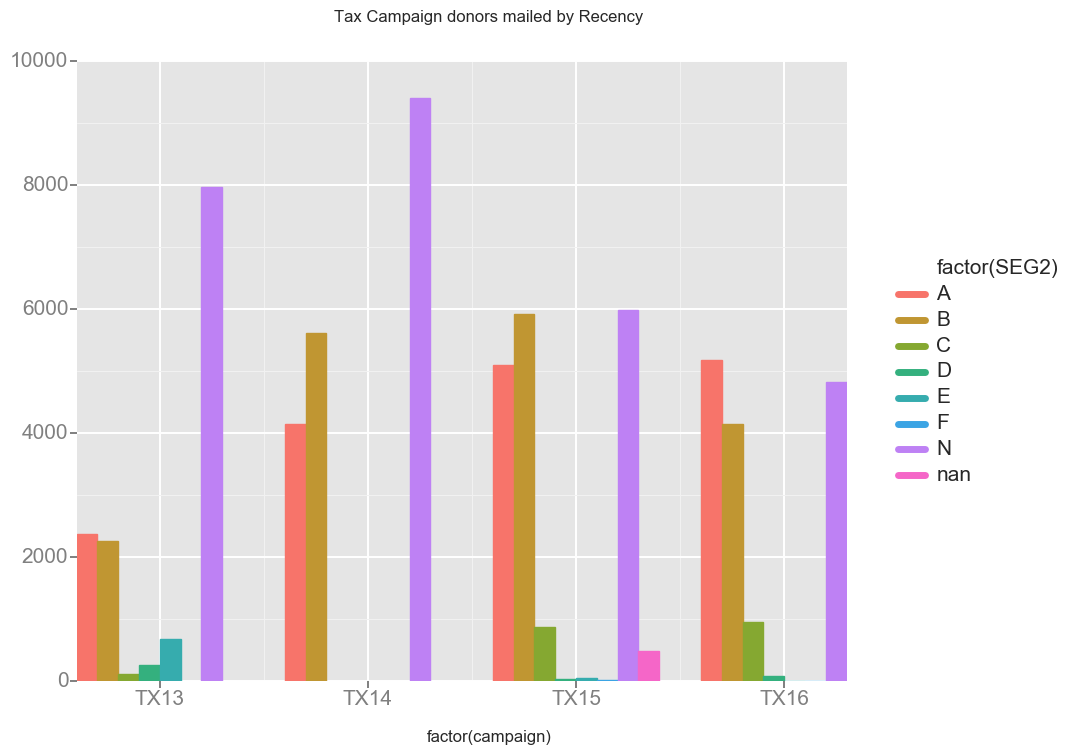

<ggplot: (14128517)>

In [10]:
ggplot(aes(x='factor(campaign)', fill='factor(SEG2)'), data=df) +\
            geom_bar() +\
            ggtitle('Tax Campaign donors mailed by Recency') +\
            scale_color_manual('Red')

In [11]:
# Look at the proportion of donors in each campaign by segment2 (recency)
pd.crosstab( df['campaign'], df['SEG2']).apply(lambda c: c/c.sum(), axis=1)

SEG2,A,B,C,D,E,F,N
campaign,,,,,,,
TX13,0.173865,0.165447,0.008638,0.018375,0.049854,0.000000,0.583821
TX14,0.216354,0.292752,0.000000,0.000000,0.000000,0.000000,0.490894
TX15,0.283742,0.329103,0.048923,0.002059,0.002393,0.001057,0.332721
TX16,0.340586,0.272877,0.062977,0.005653,0.000394,0.000263,0.317250


We see that the 2013 and 2014 campaigns were primarily dominated with new donors and there has been a trend of mailing less new donors as acquisition activity has slowed down. Most recently, our mailing data has been split almost evenly at 1/3 for New, Active and B donors. Below, we look at the response rates for each campaign split by our recency segment:


### Response rates

In [12]:
campaigns_grouped_seg2_gp = df.groupby(['SEG2','campaign'])

campaigns_grouped_seg2_gp['donated'].value_counts().unstack().apply(lambda c: c/c.sum(), axis=1)

donated               0         1
SEG2 campaign                    
A    TX13      0.738526  0.261474
     TX14      0.709841  0.290159
     TX15      0.639074  0.360926
     TX16      0.665316  0.334684
B    TX13      0.965929  0.034071
     TX14      0.950089  0.049911
     TX15      0.912396  0.087604
     TX16      0.928451  0.071549
C    TX13      0.949153  0.050847
     TX15      0.914676  0.085324
     TX16      0.967641  0.032359
D    TX13      0.960159  0.039841
     TX15      0.891892  0.108108
     TX16      0.918605  0.081395
E    TX13      0.985316  0.014684
     TX15      0.953488  0.046512
     TX16      1.000000       NaN
F    TX15      1.000000       NaN
     TX16      1.000000       NaN
N    TX13      0.892915  0.107085
     TX14      0.848411  0.151589
     TX15      0.825527  0.174473
     TX16      0.876088  0.123912

* We see that overall the best performing segment are our **active donors, responding on average at 30% and over.**
* New donors respond at approximately 13%, followed by B,C and D donors who respond at approximately 5-7%.


* Hence, it may be valuable to refine and improve our selection in the new and lapsed segments to achieve the greatest cost savings. For Active donors, since the response rates are generally quite high, mailing the entire segment is appropriate.


### Drill down to Value Band

In [13]:
# Group by SEG3 as well
campaigns_grouped_active_gp = df.loc[df['SEG2']=='A',:].groupby(['SEG3', 'campaign'])

campaigns_grouped_active_gp['donated'].value_counts().unstack().apply(lambda c: c/c.sum(), axis=1)

donated               0         1
SEG3 campaign                    
1.0  TX14      0.627451  0.372549
     TX15      0.515464  0.484536
     TX16      0.620370  0.379630
2.0  TX13      0.592920  0.407080
     TX14      0.628866  0.371134
     TX15      0.546667  0.453333
     TX16      0.562500  0.437500
3.0  TX13      0.673820  0.326180
     TX14      0.647619  0.352381
     TX15      0.591071  0.408929
     TX16      0.634315  0.365685
4.0  TX13      0.701439  0.298561
     TX14      0.684086  0.315914
     TX15      0.612670  0.387330
     TX16      0.659668  0.340332
5.0  TX13      0.773931  0.226069
     TX14      0.737635  0.262365
     TX15      0.667631  0.332369
     TX16      0.682621  0.317379

We see that for active donors, those in segment 3 value bands 1,2,3,4 (those with larger last gift amounts) do tend to respond at higher rates than donors in value band 5. However, the response rates for donors in value band 5 still respond strongly overall. 

In [14]:
campaigns_grouped_new_gp = df.loc[df['SEG2']=='N',:].groupby(['SEG3', 'campaign'])

campaigns_grouped_new_gp['donated'].value_counts().unstack().apply(lambda c: c/c.sum(), axis=1)

donated               0         1
SEG3 campaign                    
1.0  TX13      0.941176  0.058824
     TX14      0.714286  0.285714
     TX15      0.709677  0.290323
     TX16      0.826923  0.173077
2.0  TX13      0.909091  0.090909
     TX14      0.758621  0.241379
     TX15      0.651515  0.348485
     TX16      0.765432  0.234568
3.0  TX13      0.852512  0.147488
     TX14      0.799692  0.200308
     TX15      0.786207  0.213793
     TX16      0.817722  0.182278
4.0  TX13      0.889336  0.110664
     TX14      0.816270  0.183730
     TX15      0.787758  0.212242
     TX16      0.871921  0.128079
5.0  TX13      0.897757  0.102243
     TX14      0.864442  0.135558
     TX15      0.844556  0.155444
     TX16      0.887907  0.112093

In terms of value band segments, the pattern of behaviour in new donors is similar to active donors in that band 5 donors generally have the lowest response rates of the group.

In [15]:
campaigns_grouped_lapsed_gp = df.loc[df['SEG2']=='B',:].groupby(['SEG3', 'campaign'])

campaigns_grouped_lapsed_gp['donated'].value_counts().unstack().apply(lambda c: c/c.sum(), axis=1)

donated               0         1
SEG3 campaign                    
1.0  TX14      0.813953  0.186047
     TX15      0.852941  0.147059
     TX16      0.812500  0.187500
2.0  TX13      0.875000  0.125000
     TX14      0.769231  0.230769
     TX15      0.784946  0.215054
     TX16      0.847458  0.152542
3.0  TX13      0.926667  0.073333
     TX14      0.915842  0.084158
     TX15      0.877030  0.122970
     TX16      0.895833  0.104167
4.0  TX13      0.954106  0.045894
     TX14      0.930332  0.069668
     TX15      0.886910  0.113090
     TX16      0.919180  0.080820
5.0  TX13      0.974159  0.025841
     TX14      0.962065  0.037935
     TX15      0.926040  0.073960
     TX16      0.937824  0.062176

Lapsed donors also behave similarly. **This particular drill-down is revealing: although the B segment overall responds at approximately 4-8%, we see that those in value bands 1 and 2 actually respond at rates closer to new donors. This suggests that it may be worthwhile to target higher value donors in lapsed segments moving forward.**

In [16]:
campaigns_grouped_lapsedc_gp = df.loc[df['SEG2']=='C',:].groupby(['SEG3', 'campaign'])

campaigns_grouped_lapsedc_gp['donated'].value_counts().unstack().apply(lambda c: c/c.sum(), axis=1)

donated               0         1
SEG3 campaign                    
1.0  TX15      0.846154  0.153846
     TX16      1.000000       NaN
2.0  TX13      0.909091  0.090909
     TX15      0.647059  0.352941
     TX16      0.937500  0.062500
3.0  TX13      1.000000       NaN
     TX15      0.931507  0.068493
     TX16      0.905882  0.094118
4.0  TX13      0.916667  0.083333
     TX15      0.915033  0.084967
     TX16      0.971591  0.028409
5.0  TX13      0.954545  0.045455
     TX15      0.921348  0.078652
     TX16      0.975535  0.024465

The data is slightly less consistent for C donors.

# Profile of Donors by Segment

We have seen that our donors respond at different rates by our recency segment and that higher value band donors in further lapsed segments still respond well. We can now take a deeper look at each segment and see the relationship between donating to tax and other variables such as count amount and history of donating to the major DM campaigns.

## Count amount vs. Response

C:\Users\yeyau\Documents\WinPython-32bit-3.5.2.3Qt5\python-3.5.2\lib\site-packages\ggplot\ggplot.py:602: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  fill_levels = self.data[[fillcol_raw, fillcol]].sort(fillcol_raw)[fillcol].unique()


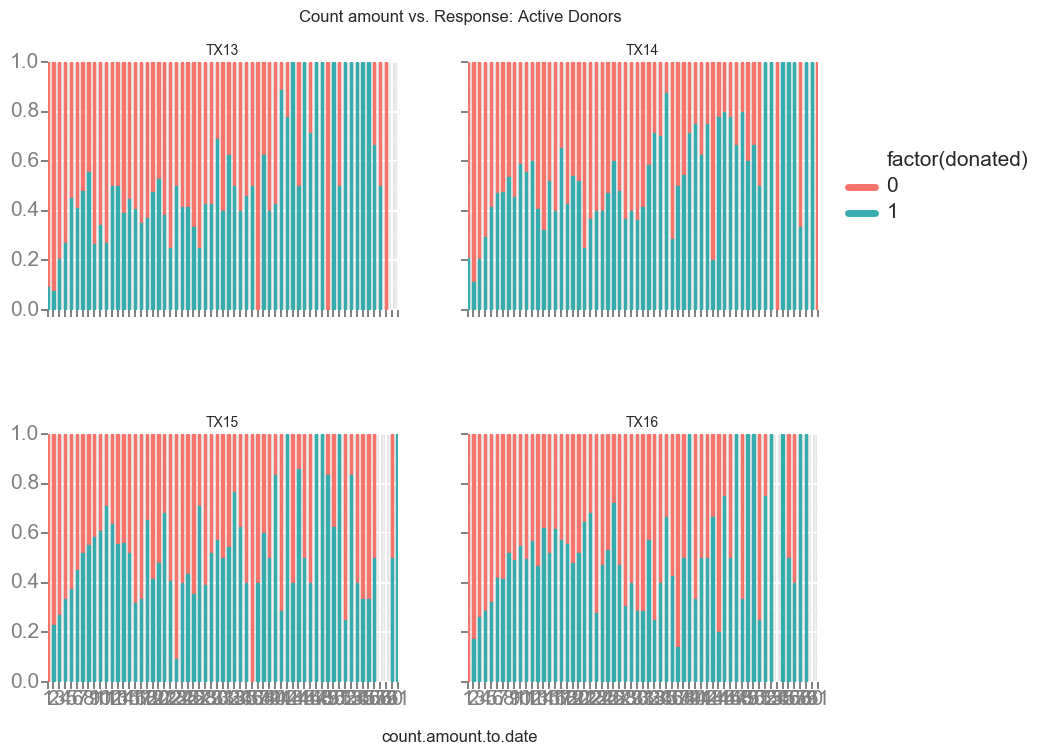

<ggplot: (4443267)>

In [16]:
campaign_list = ['TX13', 'TX14', 'TX15', 'TX16']

#for x in campaign_list:
ggplot(aes(x='count.amount.to.date', fill='factor(donated)'), data=df.loc[df['SEG2']=='A',:]) + geom_bar(binwidth=5, position='fill') +\
        facet_wrap('campaign') +\
        xlim(0,60) +\
        ggtitle('Count amount vs. Response: Active Donors')

* **We notice that for active donors, the general trend is as follows: as the number of donations made goes up, then the more likely it is that the donor responds positively to the current campaign. However, as we can see, there is a fair amount of variability here.**  

C:\Users\yeyau\Documents\WinPython-32bit-3.5.2.3Qt5\python-3.5.2\lib\site-packages\ggplot\ggplot.py:602: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  fill_levels = self.data[[fillcol_raw, fillcol]].sort(fillcol_raw)[fillcol].unique()


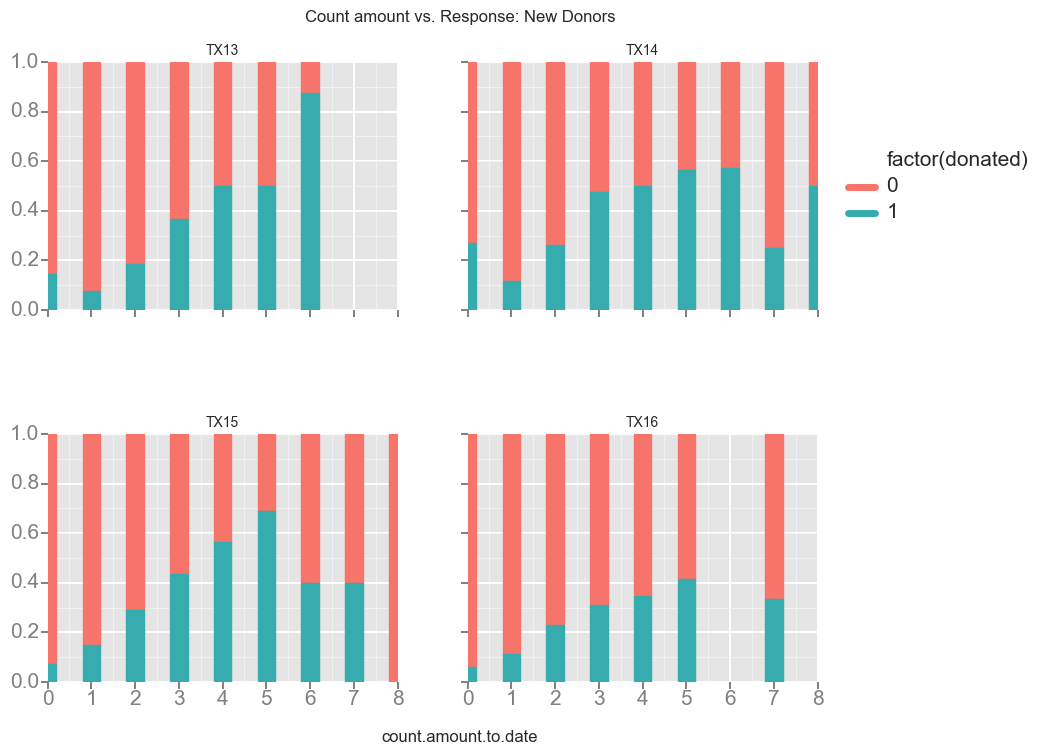

<ggplot: (14063501)>

In [49]:
ggplot(aes(x='count.amount.to.date', fill='factor(donated)'), data=df.loc[df['SEG2']=='N',:]) + geom_bar(binwidth=1, position='fill') +\
        facet_wrap('campaign') +\
        xlim(0,8) +\
        ggtitle('Count amount vs. Response: New Donors')

**In the above charts, we that up until about 5-6 gifts, new donors who have given more often are more likely to donate to the current campaign. However, this peaks at about 6 gifts, upon which donors who have already given 6 or more gifts are less likely to donate to the current campaign.**

C:\Users\yeyau\Documents\WinPython-32bit-3.5.2.3Qt5\python-3.5.2\lib\site-packages\ggplot\ggplot.py:602: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  fill_levels = self.data[[fillcol_raw, fillcol]].sort(fillcol_raw)[fillcol].unique()


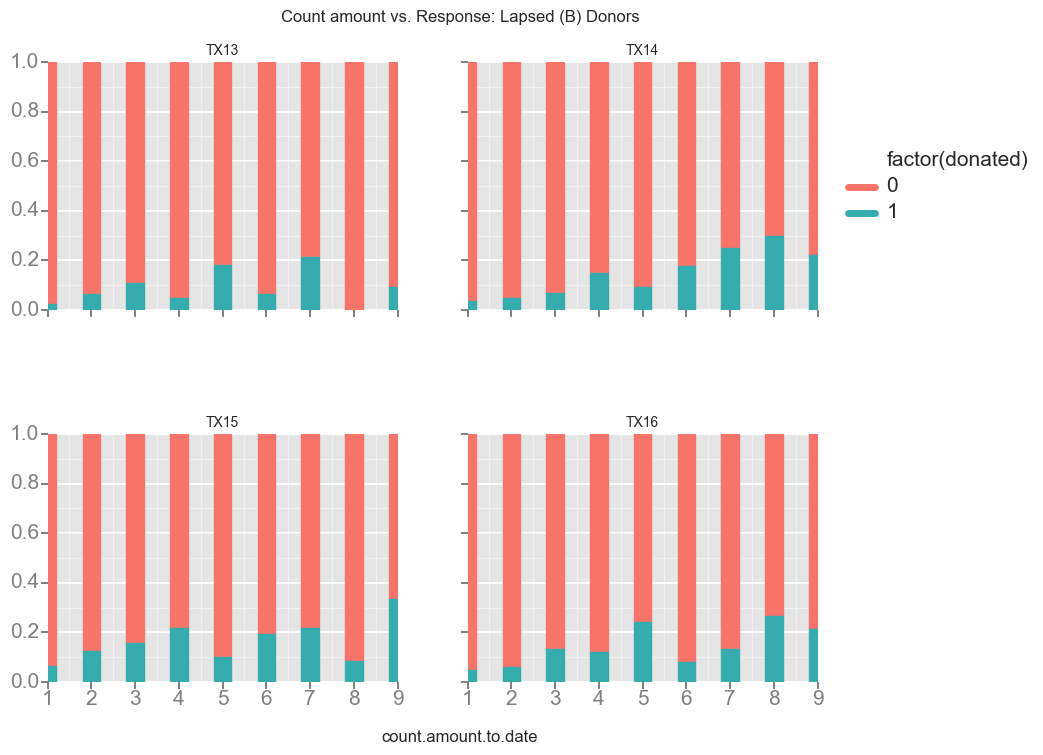

<ggplot: (29684251)>

In [50]:
ggplot(aes(x='count.amount.to.date', fill='factor(donated)'), data=df.loc[df['SEG2']=='B',:]) + geom_bar(binwidth=1, position='fill') +\
        facet_wrap('campaign') +\
        xlim(0,8) +\
        ggtitle('Count amount vs. Response: Lapsed (B) Donors')

**Lapsed donors are generally much less likely to donate regardless of count amount.**



## Months as Donor vs. Response

C:\Users\yeyau\Documents\WinPython-32bit-3.5.2.3Qt5\python-3.5.2\lib\site-packages\ggplot\ggplot.py:602: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  fill_levels = self.data[[fillcol_raw, fillcol]].sort(fillcol_raw)[fillcol].unique()


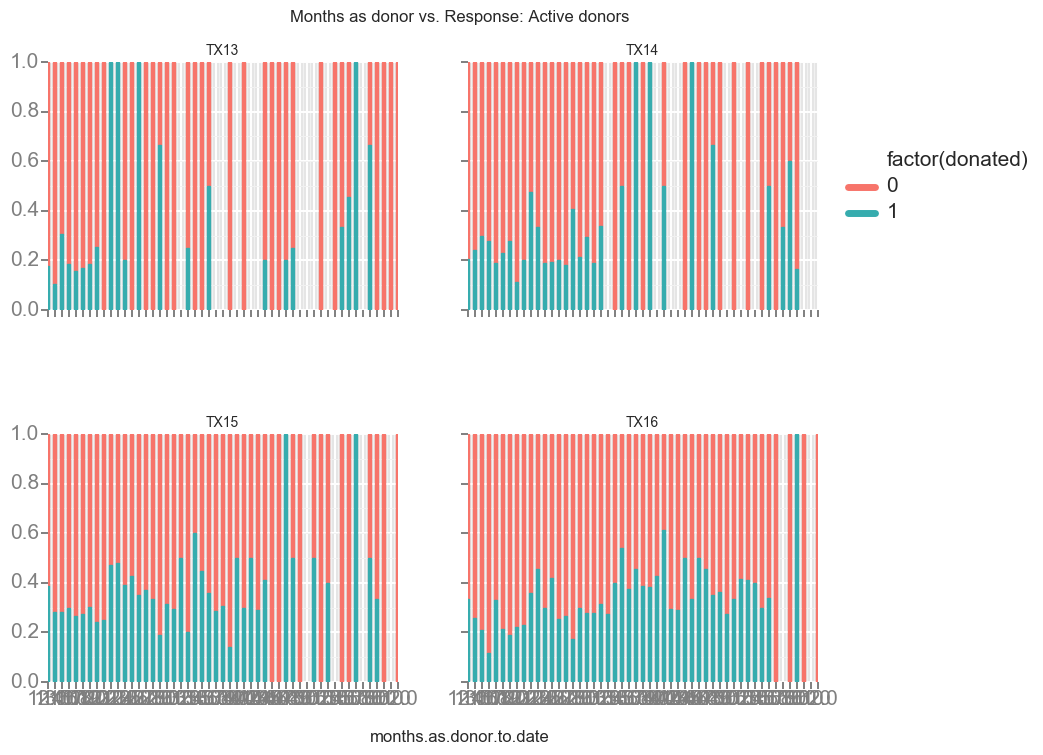

<ggplot: (44596715)>

In [127]:
ggplot(aes(x='months.as.donor.to.date', fill='factor(donated)'), data=df.loc[df['SEG2']=='A',:]) +\
        geom_bar(binwidth=1, position='fill') +\
        facet_wrap('campaign') +\
        xlim(0,50) +\
        ggtitle('Months as donor vs. Response: Active donors')

## Tax Donation History vs. Response

C:\Users\yeyau\Documents\WinPython-32bit-3.5.2.3Qt5\python-3.5.2\lib\site-packages\ggplot\ggplot.py:602: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  fill_levels = self.data[[fillcol_raw, fillcol]].sort(fillcol_raw)[fillcol].unique()


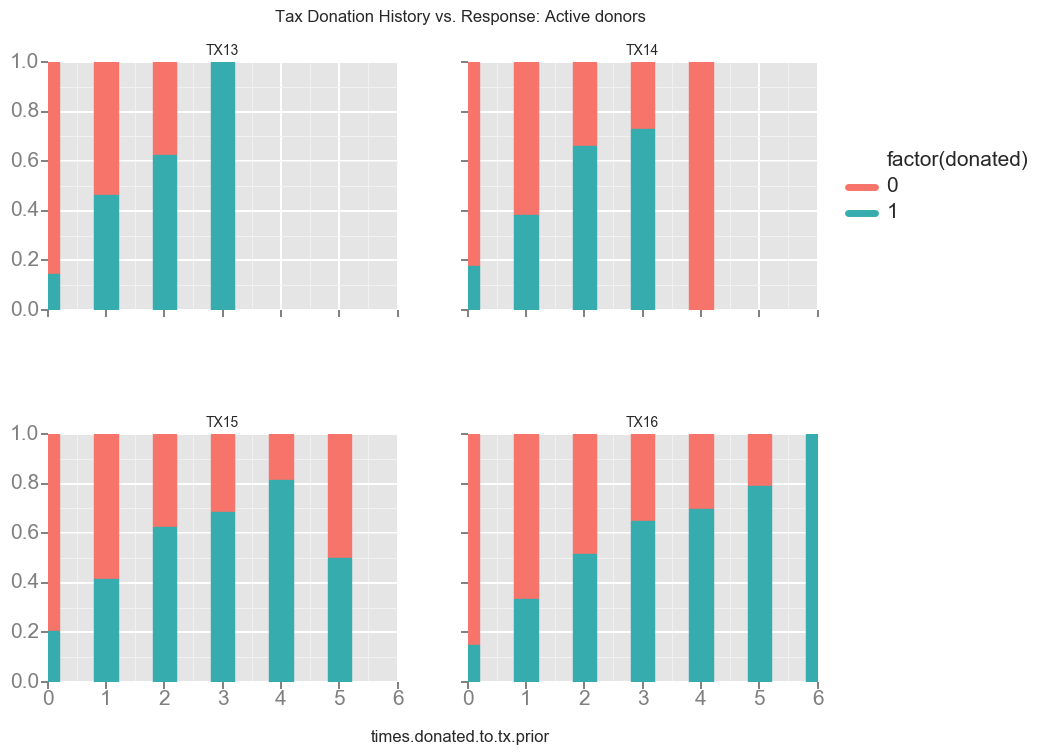

<ggplot: (14272723)>

In [51]:
ggplot(aes(x='times.donated.to.tx.prior', fill='factor(donated)'), data=df.loc[df['SEG2']=='A',:]) +\
        geom_bar(binwidth=1, position='fill') +\
        facet_wrap('campaign') +\
        xlim(0,6) +\
        ggtitle('Tax Donation History vs. Response: Active donors')

In [18]:
active_df = df.loc[df['SEG2']=='A',:]

pd.crosstab(active_df['donated'], active_df['times.donated.to.tx.prior'])

times.donated.to.tx.prior,0,1,2,3,4,5,6,7
donated,,,,,,,,
0,6709,3633,784,212,58,6,0,0
1,1403,2294,1101,427,149,20,3,1


**Clearly, active donors are much more likely to respond, when they have a history of donating to tax campaigns.** It is consistent across each year, when an active donor has given 3 or more gifts to tax, then more often than not, they have donated to the current tax campaign.

C:\Users\yeyau\Documents\WinPython-32bit-3.5.2.3Qt5\python-3.5.2\lib\site-packages\ggplot\ggplot.py:602: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  fill_levels = self.data[[fillcol_raw, fillcol]].sort(fillcol_raw)[fillcol].unique()


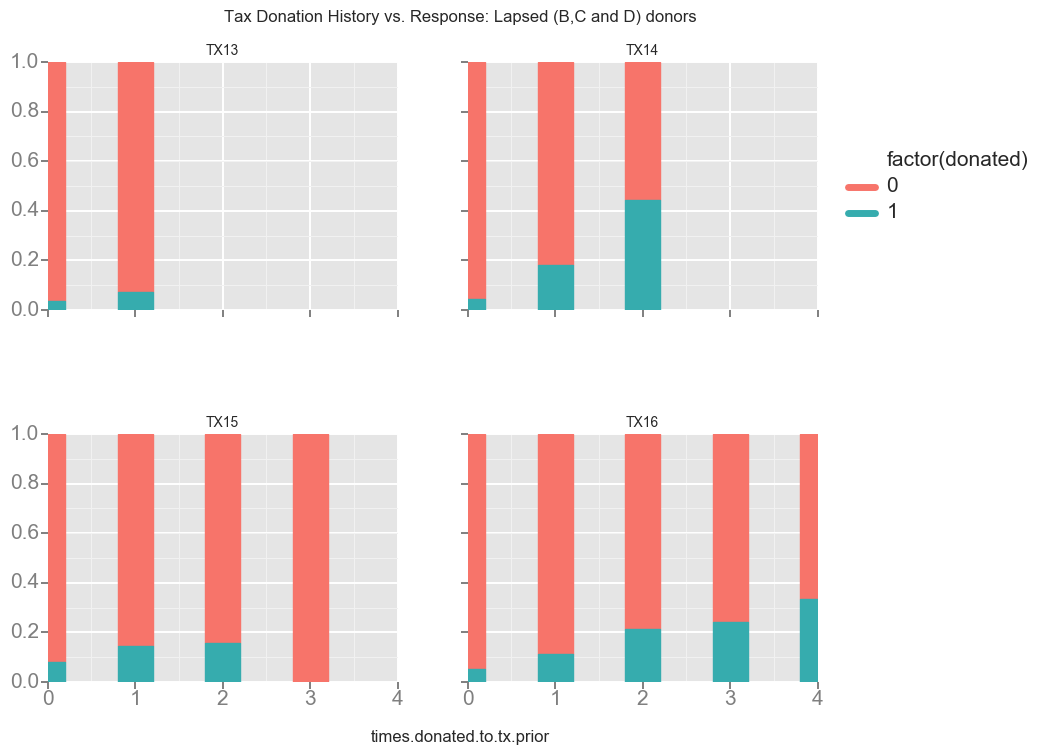

<ggplot: (33919575)>

In [52]:
ggplot(aes(x='times.donated.to.tx.prior', fill='factor(donated)'), data=df.loc[df['SEG2'].isin(['B','C','D']),:]) +\
        geom_bar(binwidth=1, position='fill') + facet_wrap('campaign') +\
        xlim(0,4) +\
        ggtitle('Tax Donation History vs. Response: Lapsed (B,C and D) donors')

It is slighty more difficult to tell what behaviour holds for lapsed donors. But a history of donating to the tax campaign does correspond to a greater proportion of lapsed donors giving to the current campaign.

## Xmas Donation History vs. Response

C:\Users\yeyau\Documents\WinPython-32bit-3.5.2.3Qt5\python-3.5.2\lib\site-packages\ggplot\ggplot.py:602: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  fill_levels = self.data[[fillcol_raw, fillcol]].sort(fillcol_raw)[fillcol].unique()


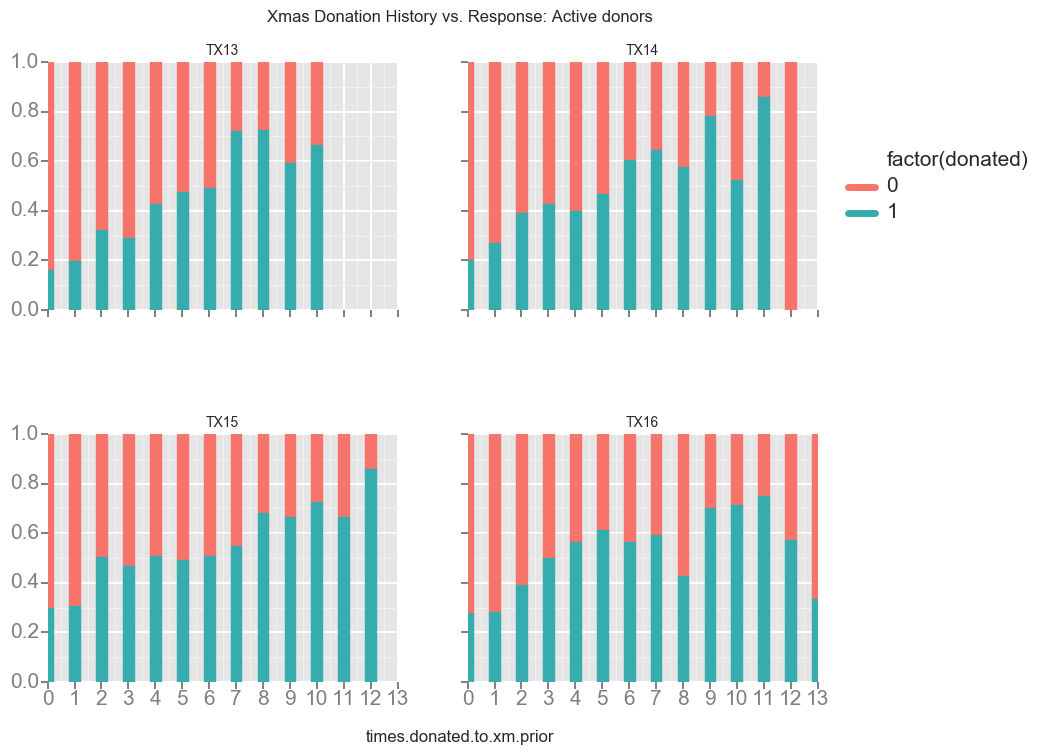

<ggplot: (33232235)>

In [53]:
ggplot(aes(x='times.donated.to.xm.prior', fill='factor(donated)'), data=df.loc[df['SEG2']=='A',:]) +\
        geom_bar(binwidth=1, position='fill') +\
        facet_wrap('campaign') +\
        xlim(0,13) +\
        ggtitle('Xmas Donation History vs. Response: Active donors')

Similarly to tax donation history, active donors who have a history of donating to xmas are more likely to give than otherwise. However this pattern is more variable than tax donation history.

C:\Users\yeyau\Documents\WinPython-32bit-3.5.2.3Qt5\python-3.5.2\lib\site-packages\ggplot\ggplot.py:602: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  fill_levels = self.data[[fillcol_raw, fillcol]].sort(fillcol_raw)[fillcol].unique()


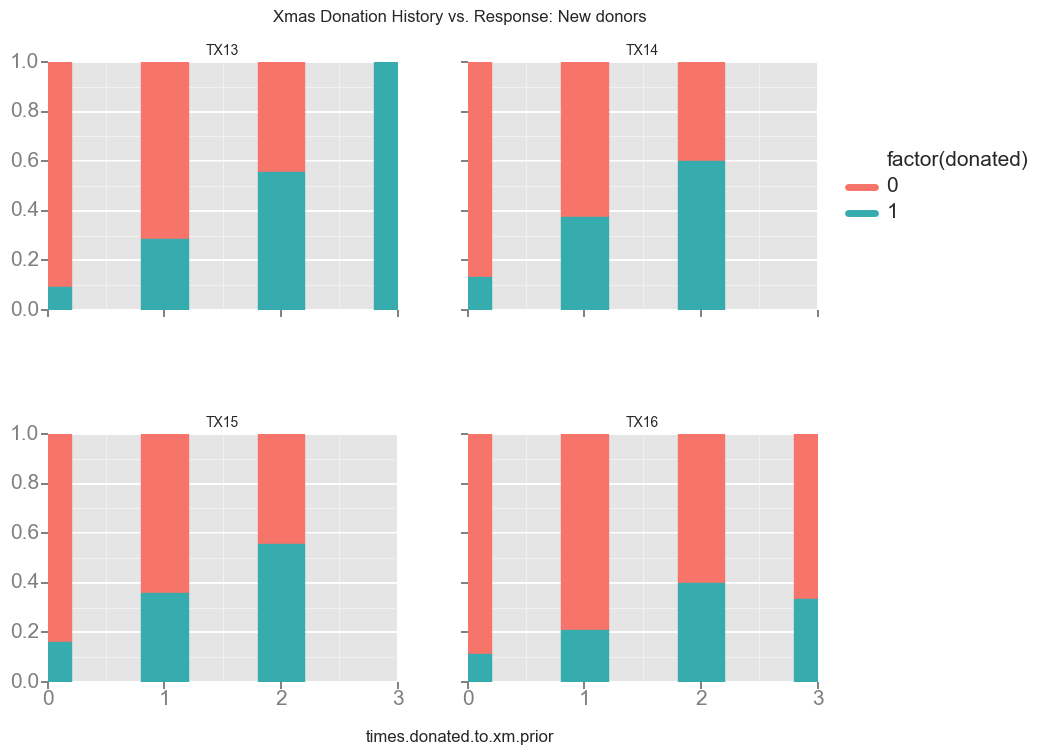

<ggplot: (35684171)>

In [54]:
ggplot(aes(x='times.donated.to.xm.prior', fill='factor(donated)'), data=df.loc[df['SEG2']=='N',:]) +\
        geom_bar(binwidth=1, position='fill') +\
        facet_wrap('campaign') +\
        xlim(0,3) +\
        ggtitle('Xmas Donation History vs. Response: New donors')

New donors are also more likely to give, having gave to the xmas campaign. Note that the chart does not indicate how many new donors have gave multiple times to the one xmas campaign.

C:\Users\yeyau\Documents\WinPython-32bit-3.5.2.3Qt5\python-3.5.2\lib\site-packages\ggplot\ggplot.py:602: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  fill_levels = self.data[[fillcol_raw, fillcol]].sort(fillcol_raw)[fillcol].unique()


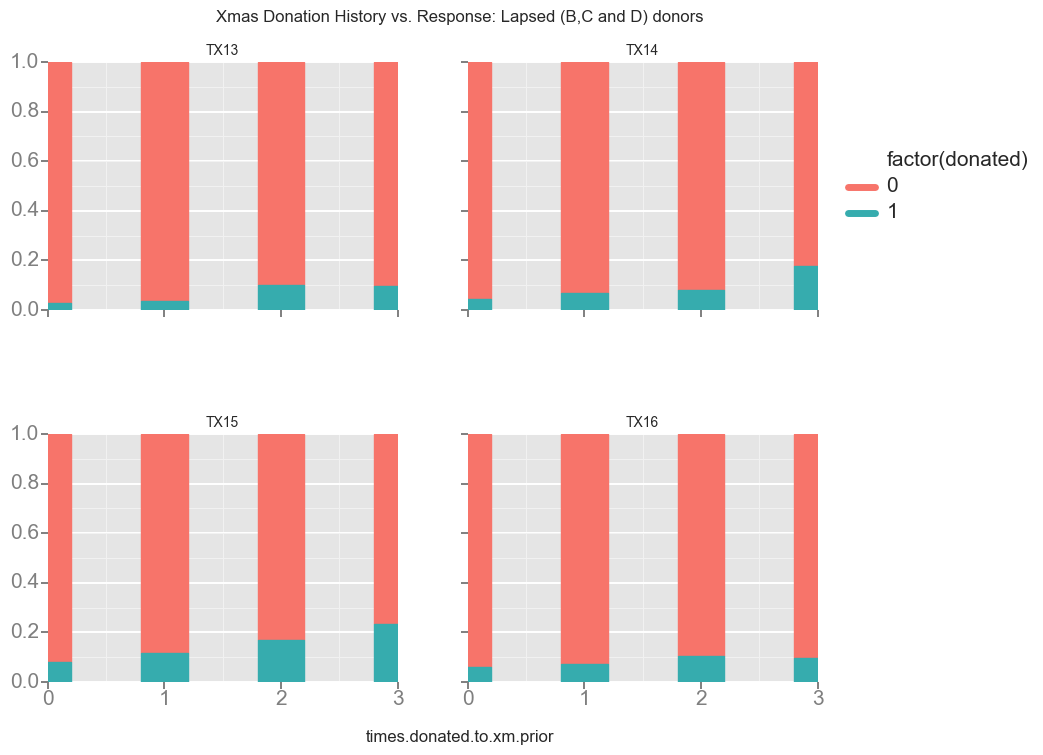

<ggplot: (27645313)>

In [55]:
ggplot(aes(x='times.donated.to.xm.prior', fill='factor(donated)'), data=df.loc[df['SEG2'].isin(['B','C','D']),:]) +\
        geom_bar(binwidth=1, position='fill') +\
        facet_wrap('campaign') +\
        xlim(0,3) +\
        ggtitle('Xmas Donation History vs. Response: Lapsed (B,C and D) donors')

## Back to School Donation History vs. Response

C:\Users\yeyau\Documents\WinPython-32bit-3.5.2.3Qt5\python-3.5.2\lib\site-packages\ggplot\ggplot.py:602: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  fill_levels = self.data[[fillcol_raw, fillcol]].sort(fillcol_raw)[fillcol].unique()


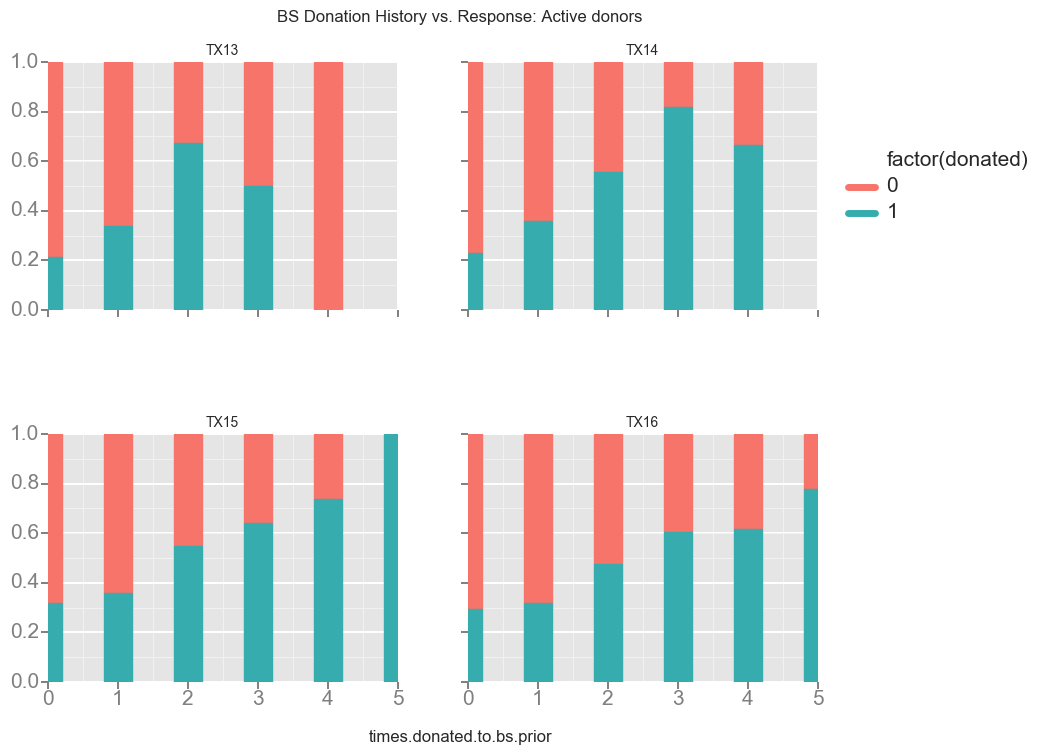

<ggplot: (15211873)>

In [56]:
ggplot(aes(x='times.donated.to.bs.prior', fill='factor(donated)'), data=df.loc[df['SEG2']=='A',:]) +\
        geom_bar(binwidth=1, position='fill') +\
        facet_wrap('campaign') +\
        xlim(0,5) +\
        ggtitle('BS Donation History vs. Response: Active donors')

As with the other two major campaigns, for active donors, a history of donating to the Back to School campaigns is well correlated to donating to the current tax campaign. In fact, compared to xmas donation history, a history of donating to BS appears to be more closely related to tax donation behaviour. The pattern is more similar and less variable.

C:\Users\yeyau\Documents\WinPython-32bit-3.5.2.3Qt5\python-3.5.2\lib\site-packages\ggplot\ggplot.py:602: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  fill_levels = self.data[[fillcol_raw, fillcol]].sort(fillcol_raw)[fillcol].unique()


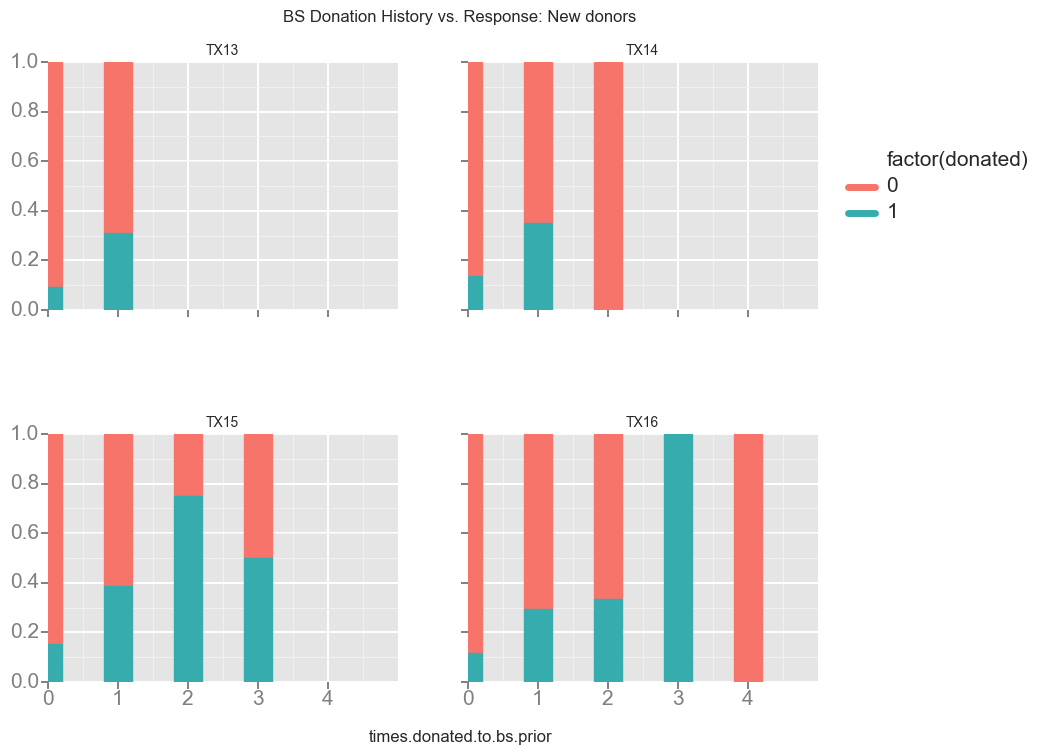

<ggplot: (37635431)>

In [57]:
ggplot(aes(x='times.donated.to.bs.prior', fill='factor(donated)'), data=df.loc[df['SEG2']=='N',:]) +\
        geom_bar(binwidth=1, position='fill') +\
        facet_wrap('campaign') +\
        xlim(0,5) +\
        ggtitle('BS Donation History vs. Response: New donors')

For new donors, having donated to the Back to School campaign also correlates well to donating to the current tax campaign.

C:\Users\yeyau\Documents\WinPython-32bit-3.5.2.3Qt5\python-3.5.2\lib\site-packages\ggplot\ggplot.py:602: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  fill_levels = self.data[[fillcol_raw, fillcol]].sort(fillcol_raw)[fillcol].unique()


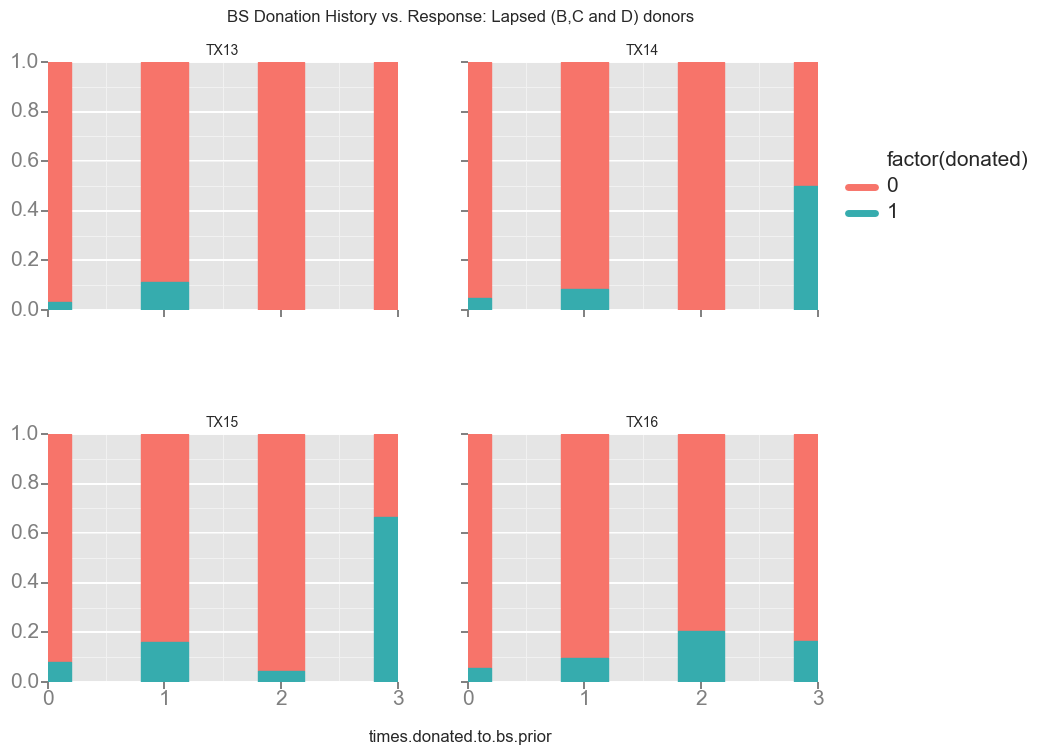

<ggplot: (39494315)>

In [58]:
ggplot(aes(x='times.donated.to.bs.prior', fill='factor(donated)'), data=df.loc[df['SEG2'].isin(['B','C','D']),:]) +\
        geom_bar(binwidth=1, position='fill') +\
        facet_wrap('campaign') +\
        xlim(0,3) +\
        ggtitle('BS Donation History vs. Response: Lapsed (B,C and D) donors')

### Regular Giving and Bequestor Status vs. Response

C:\Users\yeyau\Documents\WinPython-32bit-3.5.2.3Qt5\python-3.5.2\lib\site-packages\ggplot\ggplot.py:602: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  fill_levels = self.data[[fillcol_raw, fillcol]].sort(fillcol_raw)[fillcol].unique()


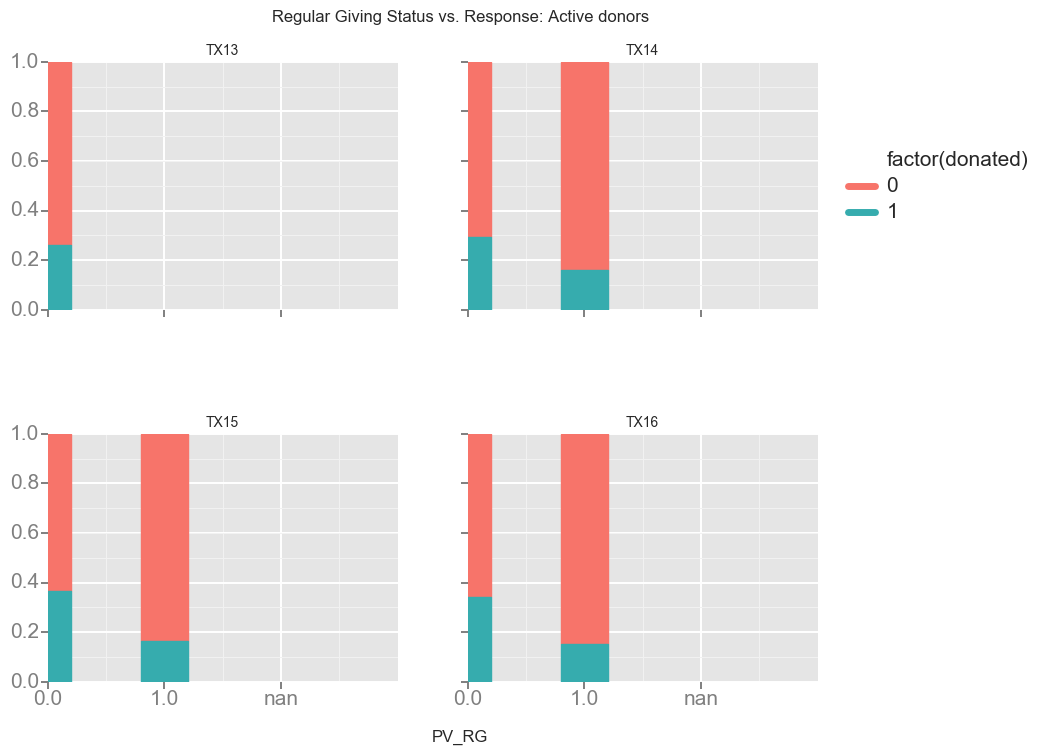

<ggplot: (29757493)>

In [60]:
ggplot(aes(x='PV_RG', fill='factor(donated)'), data=df.loc[df['SEG2'].isin(['A']),:]) +\
        geom_bar(binwidth=1, position='fill') +\
        facet_wrap('campaign') +\
        xlim(0,3) +\
        ggtitle('Regular Giving Status vs. Response: Active donors')

C:\Users\yeyau\Documents\WinPython-32bit-3.5.2.3Qt5\python-3.5.2\lib\site-packages\ggplot\ggplot.py:602: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  fill_levels = self.data[[fillcol_raw, fillcol]].sort(fillcol_raw)[fillcol].unique()


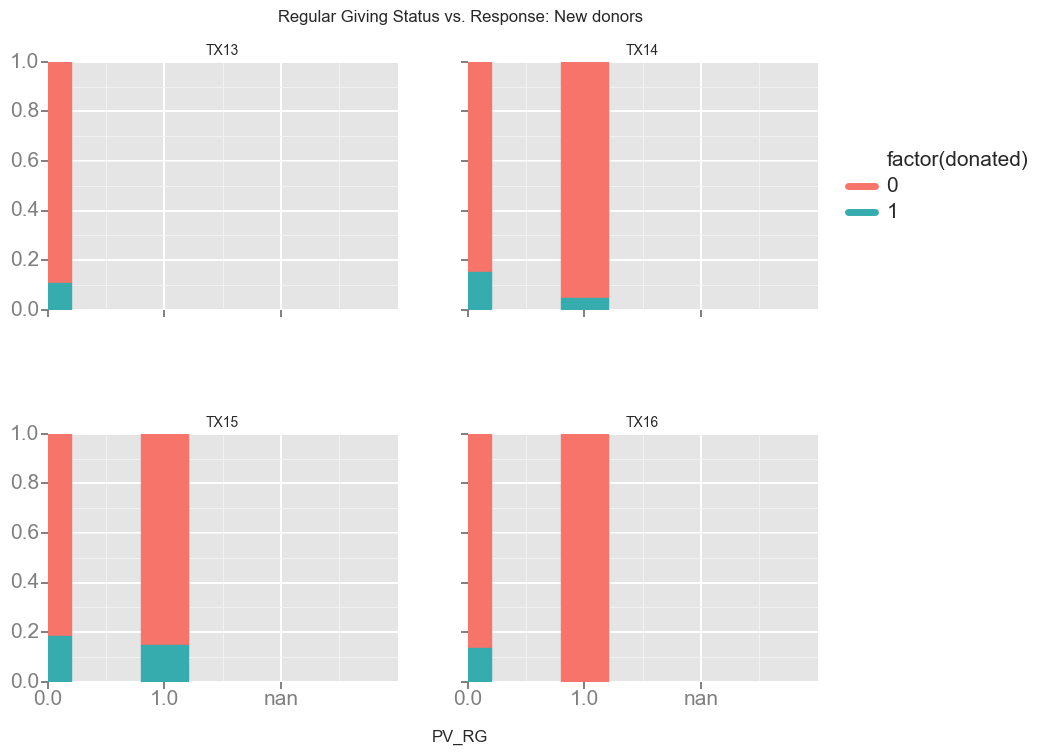

<ggplot: (39763729)>

In [61]:
ggplot(aes(x='PV_RG', fill='factor(donated)'), data=df.loc[df['SEG2'].isin(['N']),:]) +\
        geom_bar(binwidth=1, position='fill') +\
        facet_wrap('campaign') +\
        xlim(0,3) +\
        ggtitle('Regular Giving Status vs. Response: New donors')

For active and new donors, regular giving status does not appear to be an indicator of likelihood of donating to the tax campaign.

C:\Users\yeyau\Documents\WinPython-32bit-3.5.2.3Qt5\python-3.5.2\lib\site-packages\ggplot\ggplot.py:602: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  fill_levels = self.data[[fillcol_raw, fillcol]].sort(fillcol_raw)[fillcol].unique()


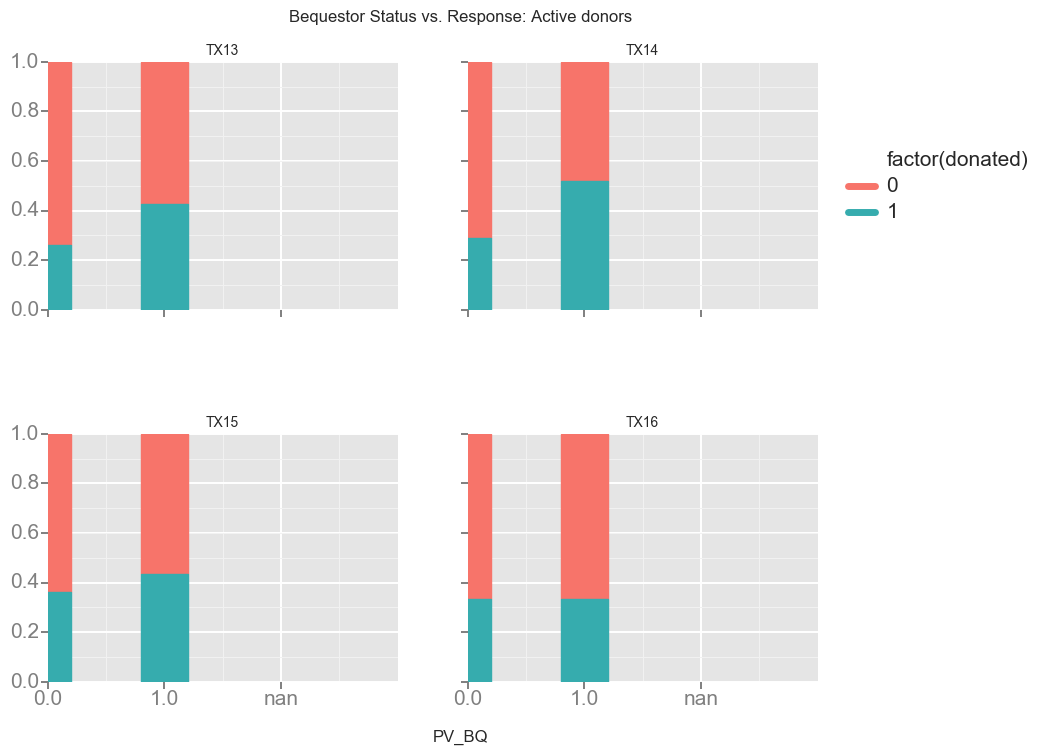

<ggplot: (35649643)>

In [62]:
ggplot(aes(x='PV_BQ', fill='factor(donated)'), data=df.loc[df['SEG2'].isin(['A']),:]) +\
        geom_bar(binwidth=1, position='fill') +\
        facet_wrap('campaign') +\
        xlim(0,3) +\
        ggtitle('Bequestor Status vs. Response: Active donors')

C:\Users\yeyau\Documents\WinPython-32bit-3.5.2.3Qt5\python-3.5.2\lib\site-packages\ggplot\ggplot.py:602: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  fill_levels = self.data[[fillcol_raw, fillcol]].sort(fillcol_raw)[fillcol].unique()


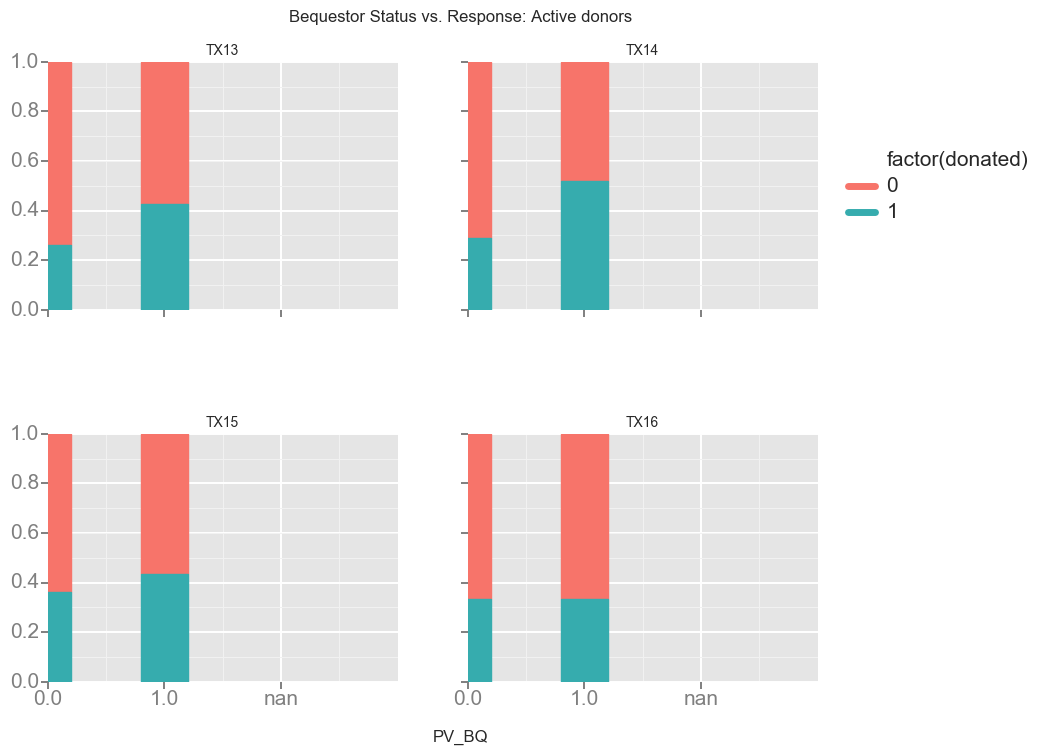

<ggplot: (41479043)>

In [63]:
ggplot(aes(x='PV_BQ', fill='factor(donated)'), data=df.loc[df['SEG2'].isin(['A']),:]) +\
        geom_bar(binwidth=1, position='fill') +\
        facet_wrap('campaign') +\
        xlim(0,3) +\
        ggtitle('Bequestor Status vs. Response: Active donors')

Proportionally, confirmed bequestors appear to be more likely to give to the tax campaign.

## A Summary of general observations

* **As we know, Active donors respond best, followed by New donors and B segment donors.**


* In the New and Active segments, value band 5 donors respond distinctively lower than the rest of the segment, although for active donors this response rate is still very good.  B segment donors in the higher value bands 1,2 respond like new donors.**


* **Overall, A history of giving to the tax campaign is well correlated to giving to the current tax campaign, much more so than a history of giving to other DM appeals.**


* **A history of giving to the back to school campaign is more closely related to giving to tax when compared to a history of giving to Christmas campaigns. Hence, is likely a marginally better predictor of tax giving**


* In general, we have seen that **for Active donors a history of donating to any of the 3 major DM campaigns corresponds well with giving to the current tax campaign.**


* **For New donors, when these donors have given to the Christmas or Back to School campaigns, they are slightly more likely to give to the current tax campaign.**


* **Lapsed donors also are slightly more likely to give to the tax campaign, having given previously to one of the three major DM campaigns.**


* **Being a regular giver does not appear to be related to giving to the tax campaign. Being a confirmed bequestor appears to be slightly related to giving to tax.**


* We could also look at the combined effects of having given to two ofthe campaigns etc, but for now, we'll try to build some predictive models first.

# Logistic Regression

In this section, we will try to optimise a Logistic regression model to determine it's effectiveness in predicting whether a donor gives to a campaign.

We'll use 5-fold cross validation to validate the model.

In [26]:
# check if any of the predictor columns have nulls
df.isnull().sum()

SERIALNUMBER                            0
SEG1                                    0
SEG2                                  477
SEG3                                  477
SEG4                                  477
PV_RG                                2541
PV_BQ                                 935
campaign                                0
campaigndate                            0
times.donated.to.tx.prior               0
times.donated.to.xm.prior               0
times.donated.to.bs.prior               0
times.donated.in.year.already           0
times.asked.for.tx.since.13             0
donated                                 0
amount.donated                          0
DateOfPayment                       55581
months.as.donor.to.date                 0
count.amount.to.date                    0
sum.amount.to.date                   1739
average.no.of.donations.per.year       20
ADDRESSLINE3                          484
ADDRESSLINE4                          492
dtype: int64

In [27]:
# drop the 20 null 'average.no.of.donations.per.year' records from dataset 
# (In order to run the regression, no columns can have nulls!)
df.dropna(subset=['average.no.of.donations.per.year'], how='any', inplace=True)

# Do the same for PV_RG and PV_BQ
df.dropna(subset=['PV_RG', 'PV_BQ'], how='any', inplace=True)

# check how many nulls after
df.isnull().sum()

SERIALNUMBER                            0
SEG1                                    0
SEG2                                    0
SEG3                                    0
SEG4                                    0
PV_RG                                   0
PV_BQ                                   0
campaign                                0
campaigndate                            0
times.donated.to.tx.prior               0
times.donated.to.xm.prior               0
times.donated.to.bs.prior               0
times.donated.in.year.already           0
times.asked.for.tx.since.13             0
donated                                 0
amount.donated                          0
DateOfPayment                       53399
months.as.donor.to.date                 0
count.amount.to.date                    0
sum.amount.to.date                    195
average.no.of.donations.per.year        0
ADDRESSLINE3                          466
ADDRESSLINE4                          474
dtype: int64

In [28]:
df.shape

(63938, 23)

In [29]:
# manually add intercept for logistic regression
df['intercept'] = 1.0

predictors = ['times.donated.to.tx.prior', 'times.donated.to.xm.prior', 'times.donated.to.bs.prior',
               'times.donated.in.year.already', 'months.as.donor.to.date', 'count.amount.to.date', 
               'average.no.of.donations.per.year', 'PV_BQ', 'intercept']

df.dropna(subset=predictors, how='any', inplace=True)

df.isnull().sum()

SERIALNUMBER                            0
SEG1                                    0
SEG2                                    0
SEG3                                    0
SEG4                                    0
PV_RG                                   0
PV_BQ                                   0
campaign                                0
campaigndate                            0
times.donated.to.tx.prior               0
times.donated.to.xm.prior               0
times.donated.to.bs.prior               0
times.donated.in.year.already           0
times.asked.for.tx.since.13             0
donated                                 0
amount.donated                          0
DateOfPayment                       53399
months.as.donor.to.date                 0
count.amount.to.date                    0
sum.amount.to.date                    195
average.no.of.donations.per.year        0
ADDRESSLINE3                          466
ADDRESSLINE4                          474
intercept                         

#### Logistic Regression Model for Active donors

In [30]:
active_df = df.loc[df['SEG2']=='A',:]

In [70]:
print(sm.Logit(active_df['donated'], active_df[predictors]).fit().summary())

Optimization terminated successfully.
         Current function value: 0.556990
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:                donated   No. Observations:                16796
Model:                          Logit   Df Residuals:                    16787
Method:                           MLE   Df Model:                            8
Date:                Fri, 28 Apr 2017   Pseudo R-squ.:                  0.1129
Time:                        13:32:09   Log-Likelihood:                -9355.2
converged:                       True   LL-Null:                       -10546.
                                        LLR p-value:                     0.000
                                       coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
times.donated.to.tx.prior            0.6908      0.022     31.19

The value of the Logistic regression model in Statsmodels lies in the presentation of the summary statistics, whereas in sklearn (developed primarily for machine learning) provides less details. The logistic regression model gives us some interpretibility of the model:

* The model verifies some of the observations from our statistical summary. In particular, **holding other values constant, the donor who has donated more often to tax before, will more likely donate to the current campaign. The same pattern is followed to a lesser degree, by having donated to Back to School and then Christmas.**


* As expected, **holding other values constant, donors who average a larger number of donations per year are also more likely to donate to the current campaign.** 


* Donors who have donated more in the current year, are less likely to donate, however the $p$-value against the parameter indicates that this variable may not be a good predictor. Similarly, the count amount to date parameter is not significant, this is likely due to confounding with the times donated in year already variable. It would be sensible to remove this variable from the model.


* The $p$-value of the confirmed bequestor variable, indicates that the PV_BQ is not significant in the model in the presence of the other variables.


* Overall, the $R$-squared value of 0.11 indicates that the model is not a good fit to the data.

In [72]:
# re-run model dropping the count.amount.to.date and PV_BQ variables

predictors2 = ['times.donated.to.tx.prior', 'times.donated.to.xm.prior', 'times.donated.to.bs.prior',
               'times.donated.in.year.already', 'months.as.donor.to.date', 
               'average.no.of.donations.per.year', 'intercept']

print(sm.Logit(active_df['donated'], active_df[predictors2]).fit().summary())

Optimization terminated successfully.
         Current function value: 0.557066
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:                donated   No. Observations:                16796
Model:                          Logit   Df Residuals:                    16789
Method:                           MLE   Df Model:                            6
Date:                Fri, 28 Apr 2017   Pseudo R-squ.:                  0.1128
Time:                        13:36:34   Log-Likelihood:                -9356.5
converged:                       True   LL-Null:                       -10546.
                                        LLR p-value:                     0.000
                                       coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
times.donated.to.tx.prior            0.6889      0.022     31.18

Dropping the count.amount.to.date variable as well as the BQ variable does not change the model very much. We might as well run the model using only the times.donated.to.tx.prior variable, as this appears to be the strongest variable in the logistic regression output.

In [31]:
print(sm.Logit(active_df['donated'], active_df['times.donated.to.tx.prior']).fit().summary())

Optimization terminated successfully.
         Current function value: 0.692944
         Iterations 3
                           Logit Regression Results                           
Dep. Variable:                donated   No. Observations:                16796
Model:                          Logit   Df Residuals:                    16795
Method:                           MLE   Df Model:                            0
Date:                Wed, 03 May 2017   Pseudo R-squ.:                 -0.1036
Time:                        10:09:37   Log-Likelihood:                -11639.
converged:                       True   LL-Null:                       -10546.
                                        LLR p-value:                       nan
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
times.donated.to.tx.prior     0.0342      0.013      2.611      0.009       0.

Using the times donated to tax variable is not enough to build a reasonable predictive model.

### 5-fold cross-validation using logistic regression

#### Using accuracy scoring method

In [73]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn import metrics

# evaluate the model using 5-fold cross-validation and scoring method of accuracy of predictions
scores = cross_val_score(LogisticRegression(), active_df[predictors], active_df['donated'], scoring='accuracy', cv=5)
print(scores)

print(scores.mean())

[ 0.73065476  0.7139881   0.69464286  0.70458606  0.6777844 ]
0.704331234578


Using 5-fold cross validation, we see that the model on average only has a 70% accuracy rate. Since on average about 70% of active donors do not donate, the model does not do a better job than merely just guessing.

In [74]:
# instantiate a logistic regression model, and fit with X and y
model = LogisticRegression()
model = model.fit(active_df[predictors], active_df['donated'])

# check the accuracy on the training set
predicted = model.predict(active_df[predictors])
print(metrics.accuracy_score(active_df['donated'], predicted))

0.724279590379


In [90]:
from sklearn.model_selection import KFold

def kf_lg(k_splits, dataset, prediction_cols, y, prob_as_yes):
    '''Function to output the results of a k-fold cross validation logistic regression model, input how many splits,
        the dataset, the prediction columns, the variable you want to predict and the probability to classfiy as yes.'''
    
    kf = KFold(n_splits= k_splits)

    model = LogisticRegression()
    
    #reset index to split the data correctly
    dataset = dataset.reset_index()    
    
    # to display average prediction accuracy, tpr and fpr
    correct_percent = 0
    tpr = 0
    fpr = 0
    
    for train_index, test_index in kf.split(dataset):
        
        train_set = dataset.loc[train_index,:]
        test_set = dataset.loc[test_index,:]
                
        # fit the model on training set
        model = model.fit(train_set.loc[:, prediction_cols], train_set.loc[:, y])
        
        # get prediction probabilities on test set ( [:,1] sets the right value of predict_proba as the predicted yes prob )
        test_set.loc[:, 'predicted_prob'] = model.predict_proba(test_set.loc[:, prediction_cols])[:,1]
    
        # predict as donate when probability >= 0.4
        test_set.loc[:, 'prediction'] = np.where(test_set.loc[:, 'predicted_prob'] >= prob_as_yes, 1, 0)
        
        # column to determine if prediction is correct or not
        test_set.loc[:, 'correct_incorrect'] = np.where( ( (test_set.loc[:, 'donated']==1) & (test_set.loc[:, 'prediction'] == 1) ) |
                                    ( (test_set.loc[:, 'donated']==0) & (test_set.loc[:, 'prediction'] == 0) ), 'correct', 'incorrect')
        
        # If you want to see the percentage of correct/incorrect
        #print(test_set.loc[:,'correct_incorrect'].value_counts(normalize=True))
        
        # get correct percentage
        number_correct = len(test_set.loc[test_set['correct_incorrect']=='correct',:])
        test_len = len(test_set.index)
        correct_percent = correct_percent + (number_correct/test_len)
        
        # get tpr
        tp = len( test_set.loc[((test_set['donated']==1) & (test_set['prediction'] == 1)),:] )
        pos = len( test_set.loc[ test_set['donated']==1,:] )
        tpr_i = tp/pos
        
        tpr = tpr + tpr_i
        
        # get tpr
        fp = len( test_set.loc[((test_set['donated']==0) & (test_set['prediction'] == 1)),:] )
        neg = len( test_set.loc[ test_set['donated']==0,:] )
        fpr_i = fp/neg
        
        fpr = fpr + fpr_i
        
    # If you want to see the details for each of the 5 runs
    
    print('Average Prediction Accuracy: ')
    print(correct_percent/k_splits)
    
    print('Average True Positive Rate: ')
    avg_tpr = tpr/k_splits
    print(avg_tpr)
    
    print('Average False Positive Rate: ')
    avg_fpr = fpr/k_splits
    print(avg_fpr)
    
    return(avg_fpr, avg_tpr)

In [91]:
# run 5 fold logistic regression over spectrum of probabilities

def logistic_regression_performance(dataset):
    '''function to run logistic regression and display ROC curve'''
    
    tpr_fpr_list = []

    # probs
    probs = [1.0, 0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1, 0.0]

    for p in probs:
        print('Probability Threshold: ' + str(p))
        tpr_fpr_list.append(kf_lg(5, dataset, predictors, 'donated', p))
    
    plt.plot(*zip(*tpr_fpr_list), '-o')
    plt.plot([0.0, 1.0])
    plt.axis([0, 1.01, 0, 1.01])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.title('Logistic Regression Performance')
    plt.show()

Probability Threshold: 1.0
Average Prediction Accuracy: 
0.6786097229901189
Average True Positive Rate: 
0.0
Average False Positive Rate: 
0.0
Probability Threshold: 0.9
Average Prediction Accuracy: 
0.6818842767830562
Average True Positive Rate: 
0.016058004242463435
Average False Positive Rate: 
0.002749147408845268
Probability Threshold: 0.8
Average Prediction Accuracy: 
0.6887313401097265
Average True Positive Rate: 
0.05225443752021695
Average False Positive Rate: 
0.010660816546876124
Probability Threshold: 0.7
Average Prediction Accuracy: 
0.6976620380215202
Average True Positive Rate: 
0.10108845254612694
Average False Positive Rate: 
0.022016488955790732
Probability Threshold: 0.6
Average Prediction Accuracy: 
0.7067118012730547
Average True Positive Rate: 
0.1734254876728628
Average False Positive Rate: 
0.04440829422165108
Probability Threshold: 0.5
Average Prediction Accuracy: 
0.7147495534385234
Average True Positive Rate: 
0.2611512499073835
Average False Positive Rate: 


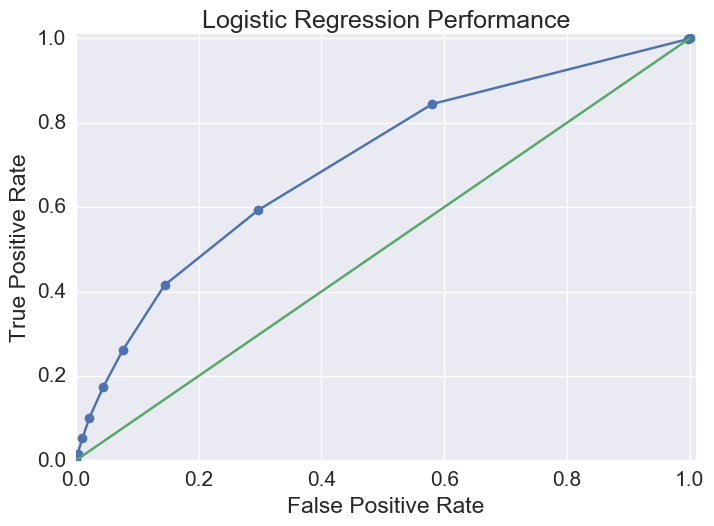

In [92]:
logistic_regression_performance(active_df)

** A strong classifier should have an ROC curve closely hugging the top left corner of the chart. Hence, we can conclude that for this set of predictors, the logistic regression model is not very good.** Whilst it is not likely that the classifier will work well for New and Lapsed donors, we'll run those models for completeness.

### Logistic Regression model for New Donors

In [93]:
new_df = df.loc[df['SEG2']=='N',:]
lapsed_df = df.loc[df['SEG2']=='B',:]

Probability Threshold: 1.0
Average Prediction Accuracy: 
0.857816702657637
Average True Positive Rate: 
0.0
Average False Positive Rate: 
0.0
Probability Threshold: 0.9
Average Prediction Accuracy: 
0.857410689634948
Average True Positive Rate: 
0.021534243821868738
Average False Positive Rate: 
0.003827282891552398
Probability Threshold: 0.8
Average Prediction Accuracy: 
0.8582965232252624
Average True Positive Rate: 
0.03867632090042873
Average False Positive Rate: 
0.005421197954986854
Probability Threshold: 0.7
Average Prediction Accuracy: 
0.8592192912418476
Average True Positive Rate: 
0.05341411634925726
Average False Positive Rate: 
0.006807494454769728
Probability Threshold: 0.6
Average Prediction Accuracy: 
0.8619136378836314
Average True Positive Rate: 
0.08943421250847212
Average False Positive Rate: 
0.00948463301824859
Probability Threshold: 0.5
Average Prediction Accuracy: 
0.8650512930080515
Average True Positive Rate: 
0.12790158193713197
Average False Positive Rate: 


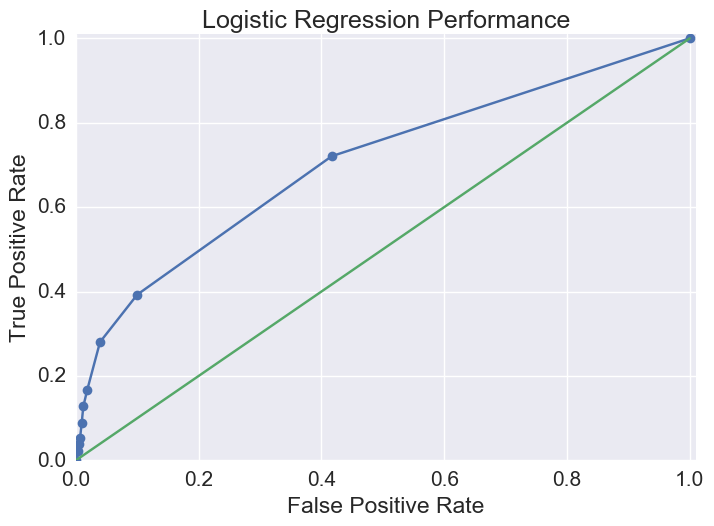

In [94]:
logistic_regression_performance(new_df)

Probability Threshold: 1.0
Average Prediction Accuracy: 
0.9346486685591258
Average True Positive Rate: 
0.0
Average False Positive Rate: 
0.0
Probability Threshold: 0.9
Average Prediction Accuracy: 
0.9338678542813789
Average True Positive Rate: 
0.0007326007326007326
Average False Positive Rate: 
0.0009055236945366737
Probability Threshold: 0.8
Average Prediction Accuracy: 
0.9333101297972741
Average True Positive Rate: 
0.003663003663003663
Average False Positive Rate: 
0.0017506791427709025
Probability Threshold: 0.7
Average Prediction Accuracy: 
0.9325850879679377
Average True Positive Rate: 
0.007326007326007326
Average False Positive Rate: 
0.0028373075762149107
Probability Threshold: 0.6
Average Prediction Accuracy: 
0.9315811994450431
Average True Positive Rate: 
0.010989010989010988
Average False Positive Rate: 
0.00422380315545264
Probability Threshold: 0.5
Average Prediction Accuracy: 
0.9306331300160412
Average True Positive Rate: 
0.01978021978021978
Average False Positiv

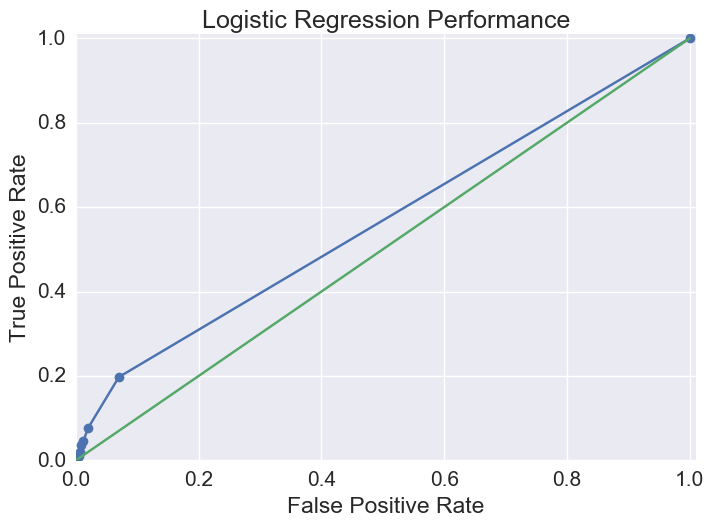

In [95]:
logistic_regression_performance(lapsed_df)

As expected, the logistic regression model is not appropriate for the other segments as well.

# Random Forest Model

We'll first split the active dataset in two, and have a look at the 2-split results and the feature importances. Then we'll run more comprehensive models, moving the predicted probabilities across the spectrum and use 5-fold cross validation.

C:\Users\yeyau\Documents\WinPython-32bit-3.5.2.3Qt5\python-3.5.2\lib\site-packages\pandas\core\indexing.py:296: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\yeyau\Documents\WinPython-32bit-3.5.2.3Qt5\python-3.5.2\lib\site-packages\pandas\core\indexing.py:476: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


correct      0.734342
incorrect    0.265658
Name: rf_correct_incorrect, dtype: float64
True Positive Rate: 0.4952450621799561
False Positive Rate: 0.15024717514124294
Feature Importances
times.donated.to.tx.prior: 0.13815231288
times.donated.to.xm.prior: 0.103643101129
times.donated.to.bs.prior: 0.0607746113819
times.donated.in.year.already: 0.0586870184165
months.as.donor.to.date: 0.345866549916
count.amount.to.date: 0.199501313655
average.no.of.donations.per.year: 0.0902411666692
PV_BQ: 0.00313392595215
intercept: 0.0


ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

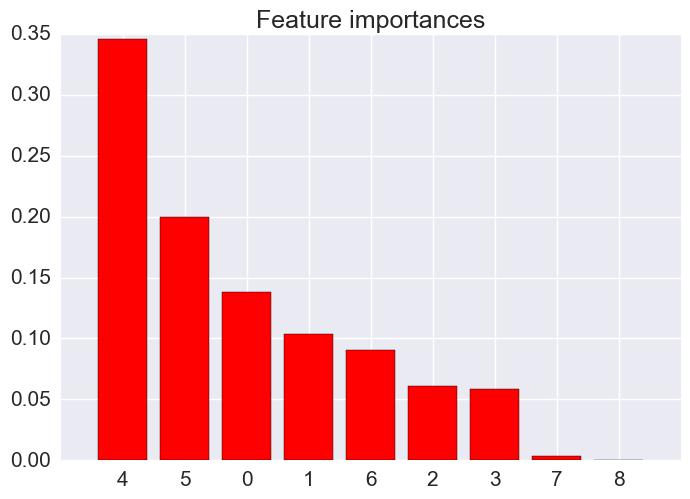

In [128]:
# Note that in newer versions of sklearn, use model_selection rather than cross_validation, which may be depreciated
import sklearn
from sklearn.cross_validation import train_test_split
from sklearn.ensemble import RandomForestClassifier

train, test = sklearn.cross_validation.train_test_split(active_df, train_size = 0.5)

forest = RandomForestClassifier(n_estimators=100)
forest = forest.fit(train.loc[:, predictors], train.loc[:, 'donated'])

test.loc[:, 'rf_prediction'] = forest.predict(test.loc[:,predictors])

test.loc[:, 'rf_correct_incorrect'] = np.where( ( (test.loc[:, 'donated']==1) & (test.loc[:, 'rf_prediction'] == 1) ) |
                                    ( (test.loc[:, 'donated']==0) & (test.loc[:, 'rf_prediction'] == 0) ), 'correct', 'incorrect')

# See the percentage of correct/incorrect
print(test.loc[:,'rf_correct_incorrect'].value_counts(normalize=True))

# True positive rate
tp = len( test.loc[((test['donated']==1) & (test['rf_prediction'] == 1)),:] )
pos = len( test.loc[ test['donated']==1,:] )
print('True Positive Rate: ' + str(tp/pos))

# False positive rate
fp = len( test.loc[((test['donated']==0) & (test['rf_prediction'] == 1)),:] )
neg = len( test.loc[ test['donated']==0,:] )
print('False Positive Rate: ' + str(fp/neg))

# Feature importances
importances = forest.feature_importances_
print('Feature Importances')
for p, imp in zip(predictors, importances):
    print(p + ': ' + str(imp))

y_pos = np.arange(len(predictors))

indices = np.argsort(importances)[::-1]

#std = np.std([tree.feature_importances_ for tree in forest.estimators_],
#             axis=0)


# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")

#plt.bar(y_pos, importances[indices],
#       color="r", yerr=std[indices], align="center")

plt.bar(y_pos, importances[indices],
       color="r", align="center")

plt.xticks(y_pos, indices)
plt.xlim([-1, y_pos])
plt.show()

In [110]:
def kf_rf(k_splits, dataset, prediction_cols, y, prob_as_yes):
    '''Function to output the results of a k-fold cross validation random forest model, input how many splits,
        the dataset, the prediction columns, the variable you want to predict and the probability to classfiy as yes.'''
    
    kf = KFold(n_splits= k_splits)

    # create random forest object
    forest = RandomForestClassifier(n_estimators=100)
    
    #reset index to split the data correctly
    dataset = dataset.reset_index()    
    
    # to display average prediction accuracy, tpr and fpr
    correct_percent = 0
    tpr = 0
    fpr = 0
    
    for train_index, test_index in kf.split(dataset):
        
        train_set = dataset.loc[train_index,:]
        test_set = dataset.loc[test_index,:]
                
        # fit the model on training set
        forest = forest.fit(train_set.loc[:, prediction_cols], train_set.loc[:, y])
        
        # get prediction probabilities on test set ( [:,1] sets the right value of predict_proba as the predicted yes prob )
        test_set.loc[:, 'rf_predicted_prob'] = forest.predict_proba(test_set.loc[:, prediction_cols])[:,1]
    
        # predict as donate when probability >= input value
        test_set.loc[:, 'rf_prediction'] = np.where(test_set.loc[:, 'rf_predicted_prob'] >= prob_as_yes, 1, 0)
        
        # Make a prediction without concern of probability
        # test_set.loc[:, 'rf_prediction'] = forest.predict(test_set.loc[:,prediction_cols])
        
        # column to determine if prediction is correct or not
        test_set.loc[:, 'rf_correct_incorrect'] = np.where( ( (test_set.loc[:, 'donated']==1) & (test_set.loc[:, 'rf_prediction'] == 1) ) |
                                    ( (test_set.loc[:, 'donated']==0) & (test_set.loc[:, 'rf_prediction'] == 0) ), 'correct', 'incorrect')
        
        # If you want to see the percentage of correct/incorrect
        #print(test_set.loc[:,'correct_incorrect'].value_counts(normalize=True))
        
        # get correct percentage
        number_correct = len(test_set.loc[test_set['rf_correct_incorrect']=='correct',:])
        test_len = len(test_set.index)
        correct_percent = correct_percent + (number_correct/test_len)
        
        # get tpr
        tp = len( test_set.loc[((test_set['donated']==1) & (test_set['rf_prediction'] == 1)),:] )
        pos = len( test_set.loc[ test_set['donated']==1,:] )
        tpr_i = tp/pos
        
        tpr = tpr + tpr_i
        
        # get tpr
        fp = len( test_set.loc[((test_set['donated']==0) & (test_set['rf_prediction'] == 1)),:] )
        neg = len( test_set.loc[ test_set['donated']==0,:] )
        fpr_i = fp/neg
        
        fpr = fpr + fpr_i
        
    # If you want to see the details for each of the 5 runs
    
    print('Average Prediction Accuracy: ')
    print(correct_percent/k_splits)
    
    print('Average True Positive Rate: ')
    avg_tpr = tpr/k_splits
    print(avg_tpr)
    
    print('Average False Positive Rate: ')
    avg_fpr = fpr/k_splits
    print(avg_fpr)
    
    return(avg_fpr, avg_tpr)

In [111]:
# run 5 fold random forest model over spectrum of probabilities

def random_forest_performance(dataset):
    '''function to run random forest model and display ROC curve'''
    
    tpr_fpr_list = []

    # probs
    probs = [1.0, 0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1, 0.0]

    for p in probs:
        print('Probability Threshold: ' + str(p))
        tpr_fpr_list.append(kf_rf(5, dataset, predictors, 'donated', p))
    
    plt.plot(*zip(*tpr_fpr_list), '-o')
    plt.plot([0.0, 1.0])
    plt.axis([0, 1.01, 0, 1.01])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.title('Random Forest Performance')
    plt.show()

Probability Threshold: 1.0
Average Prediction Accuracy: 
0.6800386665532543
Average True Positive Rate: 
0.005681256630874052
Average False Positive Rate: 
0.00045915916572305865
Probability Threshold: 0.9
Average Prediction Accuracy: 
0.6931370766526317
Average True Positive Rate: 
0.07298276176853805
Average False Positive Rate: 
0.01282997717110391
Probability Threshold: 0.8
Average Prediction Accuracy: 
0.7139166454018344
Average True Positive Rate: 
0.17660970635072498
Average False Positive Rate: 
0.034679694802243505
Probability Threshold: 0.7
Average Prediction Accuracy: 
0.7210019811735352
Average True Positive Rate: 
0.2628368052151523
Average False Positive Rate: 
0.0648747315419298
Probability Threshold: 0.6
Average Prediction Accuracy: 
0.7225499900764116
Average True Positive Rate: 
0.3713703029591349
Average False Positive Rate: 
0.11682695151710451
Probability Threshold: 0.5
Average Prediction Accuracy: 
0.7237410510497739
Average True Positive Rate: 
0.4773348466300319

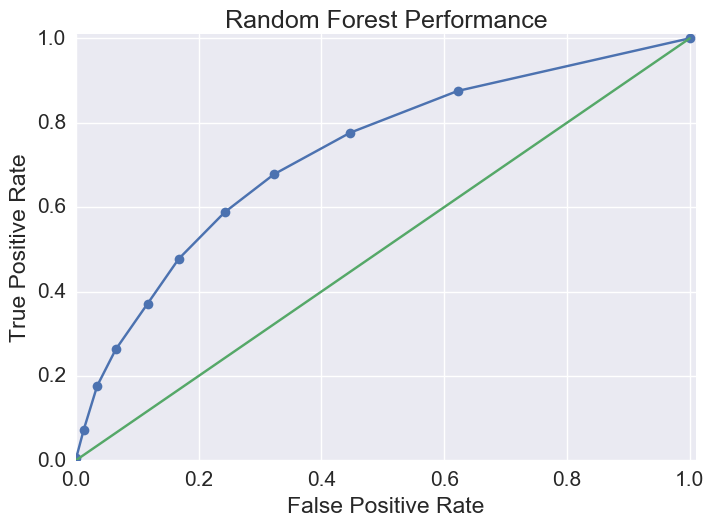

In [112]:
random_forest_performance(active_df)

Probability Threshold: 1.0
Average Prediction Accuracy: 
0.8586656426934175
Average True Positive Rate: 
0.007407975119047288
Average False Positive Rate: 
0.00012939400474444685
Probability Threshold: 0.9
Average Prediction Accuracy: 
0.8616553966258065
Average True Positive Rate: 
0.041416403540642965
Average False Positive Rate: 
0.00207695942990107
Probability Threshold: 0.8
Average Prediction Accuracy: 
0.8640177149006977
Average True Positive Rate: 
0.07454282506877913
Average False Positive Rate: 
0.004637188585132135
Probability Threshold: 0.7
Average Prediction Accuracy: 
0.8675982561664723
Average True Positive Rate: 
0.12152910087624294
Average False Positive Rate: 
0.007890325996761446
Probability Threshold: 0.6
Average Prediction Accuracy: 
0.8688904433772834
Average True Positive Rate: 
0.21018156069116317
Average False Positive Rate: 
0.021199354611436915
Probability Threshold: 0.5
Average Prediction Accuracy: 
0.8714006969039862
Average True Positive Rate: 
0.2750554820

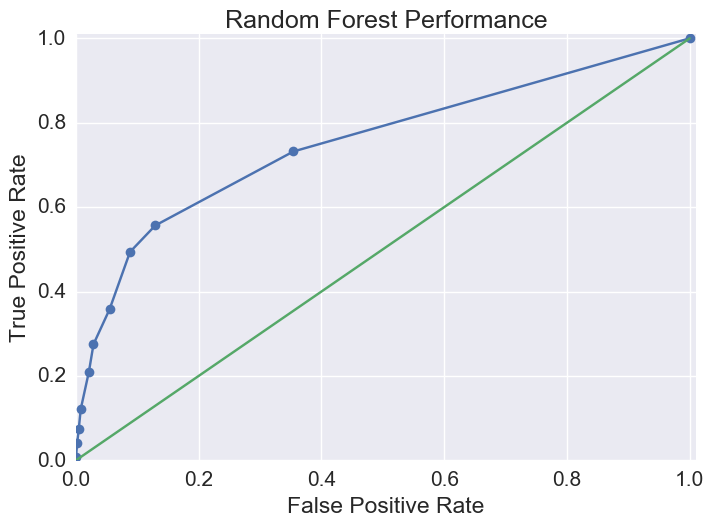

In [113]:
random_forest_performance(new_df)

## K-Nearest Neighbours Classifier

In [131]:
# Note that in newer versions of sklearn, use model_selection rather than cross_validation, which may be depreciated
import sklearn
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cross_validation import train_test_split

train, test = sklearn.cross_validation.train_test_split(active_df, train_size = 0.5)

neigh = KNeighborsClassifier(n_neighbors=5)

neigh = neigh.fit(train.loc[:, predictors], train.loc[:, 'donated'])

test.loc[:, 'nh_prediction'] = neigh.predict(test.loc[:,predictors])

test.loc[:, 'nh_correct_incorrect'] = np.where( ( (test.loc[:, 'donated']==1) & (test.loc[:, 'nh_prediction'] == 1) ) |
                                    ( (test.loc[:, 'donated']==0) & (test.loc[:, 'nh_prediction'] == 0) ), 'correct', 'incorrect')

# See the percentage of correct/incorrect
print(test.loc[:,'nh_correct_incorrect'].value_counts(normalize=True))

# True positive rate
tp = len( test.loc[((test['donated']==1) & (test['nh_prediction'] == 1)),:] )
pos = len( test.loc[ test['donated']==1,:] )
print('True Positive Rate: ' + str(tp/pos))

# False positive rate
fp = len( test.loc[((test['donated']==0) & (test['nh_prediction'] == 1)),:] )
neg = len( test.loc[ test['donated']==0,:] )
print('False Positive Rate: ' + str(fp/neg))

C:\Users\yeyau\Documents\WinPython-32bit-3.5.2.3Qt5\python-3.5.2\lib\site-packages\pandas\core\indexing.py:296: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\yeyau\Documents\WinPython-32bit-3.5.2.3Qt5\python-3.5.2\lib\site-packages\pandas\core\indexing.py:476: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


correct      0.704215
incorrect    0.295785
Name: nh_correct_incorrect, dtype: float64
True Positive Rate: 0.4454907642158638
False Positive Rate: 0.16906155756608124


In [149]:
def kf_knn(k_splits, num_neigh, dataset, prediction_cols, y, prob_as_yes, show_stats):
    '''Function to output the results of a k-fold cross validation knn model, input how many splits,
        the dataset, the prediction columns, the variable you want to predict and the probability to classfiy as yes.'''
    
    kf = KFold(n_splits= k_splits)

    # create random forest object
    neigh = KNeighborsClassifier(n_neighbors= num_neigh)
    
    #reset index to split the data correctly
    dataset = dataset.reset_index()    
    
    # to display average prediction accuracy, tpr and fpr
    correct_percent = 0
    tpr = 0
    fpr = 0
    
    for train_index, test_index in kf.split(dataset):
        
        train_set = dataset.loc[train_index,:]
        test_set = dataset.loc[test_index,:]
                
        # fit the model on training set
        neigh = neigh.fit(train_set.loc[:, prediction_cols], train_set.loc[:, y])
        
        # get prediction probabilities on test set ( [:,1] sets the right value of predict_proba as the predicted yes prob )
        test_set.loc[:, 'knn_predicted_prob'] = neigh.predict_proba(test_set.loc[:, prediction_cols])[:,1]
    
        # predict as donate when probability >= input value
        test_set.loc[:, 'knn_prediction'] = np.where(test_set.loc[:, 'knn_predicted_prob'] >= prob_as_yes, 1, 0)
        
        # Make a prediction without concern of probability
        # test_set.loc[:, 'rf_prediction'] = forest.predict(test_set.loc[:,prediction_cols])
        
        # column to determine if prediction is correct or not
        test_set.loc[:, 'knn_correct_incorrect'] = np.where( ( (test_set.loc[:, 'donated']==1) & (test_set.loc[:, 'knn_prediction'] == 1) ) |
                                    ( (test_set.loc[:, 'donated']==0) & (test_set.loc[:, 'knn_prediction'] == 0) ), 'correct', 'incorrect')
        
        # If you want to see the percentage of correct/incorrect
        #print(test_set.loc[:,'correct_incorrect'].value_counts(normalize=True))
        
        # get correct percentage
        number_correct = len(test_set.loc[test_set['knn_correct_incorrect']=='correct',:])
        test_len = len(test_set.index)
        correct_percent = correct_percent + (number_correct/test_len)
        
        # get tpr
        tp = len( test_set.loc[((test_set['donated']==1) & (test_set['knn_prediction'] == 1)),:] )
        pos = len( test_set.loc[ test_set['donated']==1,:] )
        tpr_i = tp/pos
        
        tpr = tpr + tpr_i
        
        # get tpr
        fp = len( test_set.loc[((test_set['donated']==0) & (test_set['knn_prediction'] == 1)),:] )
        neg = len( test_set.loc[ test_set['donated']==0,:] )
        fpr_i = fp/neg
        
        fpr = fpr + fpr_i
        
        
    avg_tpr = tpr/k_splits
    avg_fpr = fpr/k_splits
        
    # If you want to see the details for each of the 5 runs
    if show_stats == 'yes':
        print('Average Prediction Accuracy: ')
        print(correct_percent/k_splits)
    
        print('Average True Positive Rate: ')
        
        print(avg_tpr)
    
        print('Average False Positive Rate: ')
        print(avg_fpr)
    
    return(avg_fpr, avg_tpr)

In [150]:
# run 5 fold knn model over spectrum of probabilities

def knn_performance(dataset, num_neigh, show_stats):
    '''function to run knn model and display ROC curve'''
    
    tpr_fpr_list = []

    # probs
    probs = [1.0, 0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1, 0.0]

    for p in probs:
        #print('Probability Threshold: ' + str(p))
        tpr_fpr_list.append(kf_knn(5, num_neigh, dataset, predictors, 'donated', p, show_stats))
    
    plt.plot(*zip(*tpr_fpr_list), '-o')
    plt.plot([0.0, 1.0])
    plt.axis([0, 1.01, 0, 1.01])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.title(str(num_neigh) + '-Nearest Neighbours Performance')
    plt.show()

Probability Threshold: 1.0
Average Prediction Accuracy: 
0.6904577432342393
Average True Positive Rate: 
0.06250251143086631
Average False Positive Rate: 
0.010805201592164467
Probability Threshold: 0.9
Average Prediction Accuracy: 
0.6904577432342393
Average True Positive Rate: 
0.06250251143086631
Average False Positive Rate: 
0.010805201592164467
Probability Threshold: 0.8
Average Prediction Accuracy: 
0.7029613759764102
Average True Positive Rate: 
0.1971313042443304
Average False Positive Rate: 
0.055561891235909586
Probability Threshold: 0.7
Average Prediction Accuracy: 
0.7029613759764102
Average True Positive Rate: 
0.1971313042443304
Average False Positive Rate: 
0.055561891235909586
Probability Threshold: 0.6
Average Prediction Accuracy: 
0.7005204390479026
Average True Positive Rate: 
0.37153549531639246
Average False Positive Rate: 
0.14010871752615905
Probability Threshold: 0.5
Average Prediction Accuracy: 
0.7005204390479026
Average True Positive Rate: 
0.3715354953163924

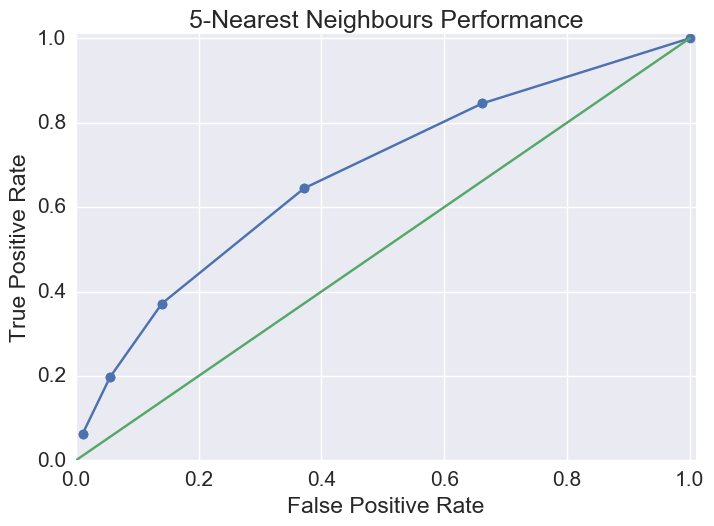

In [143]:
knn_performance(active_df,5, 'yes')

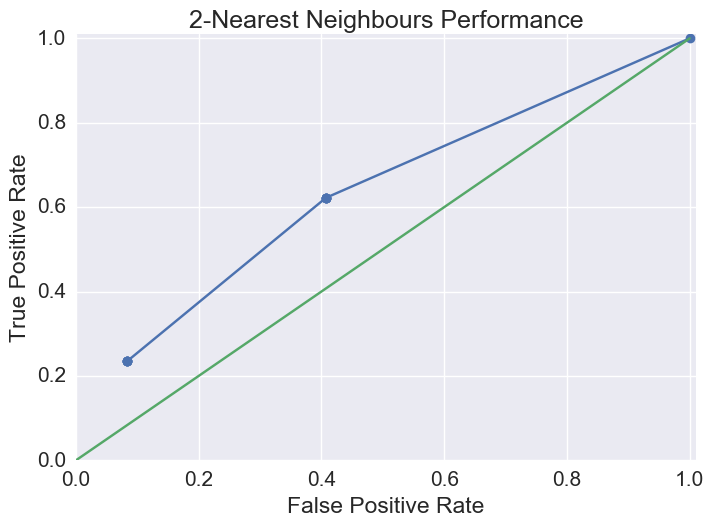

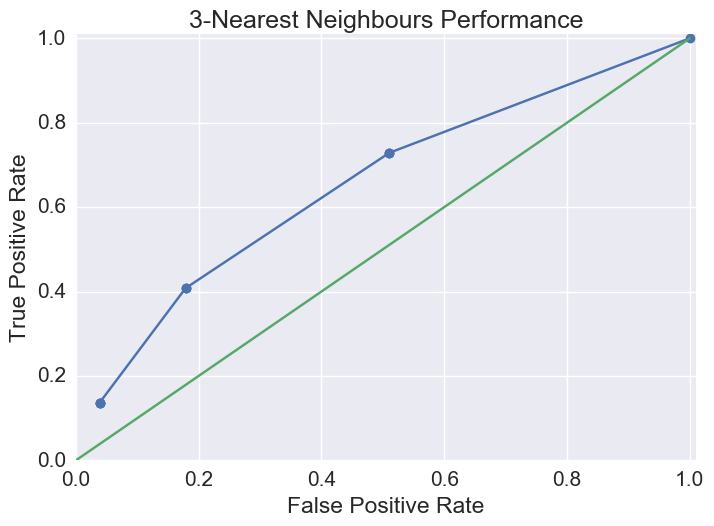

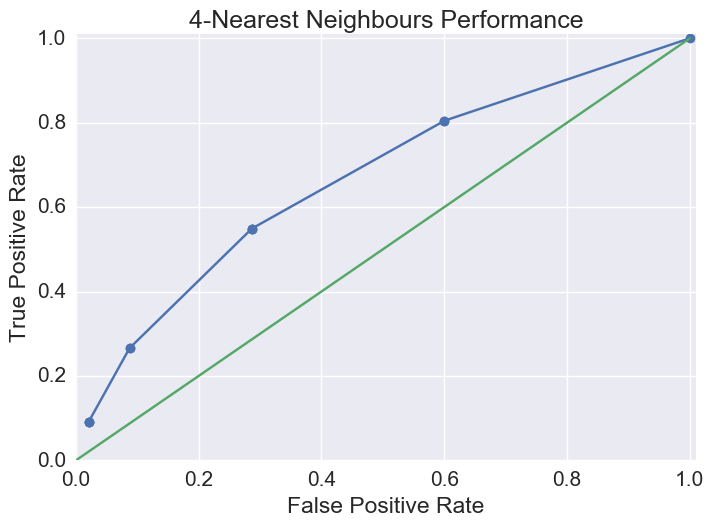

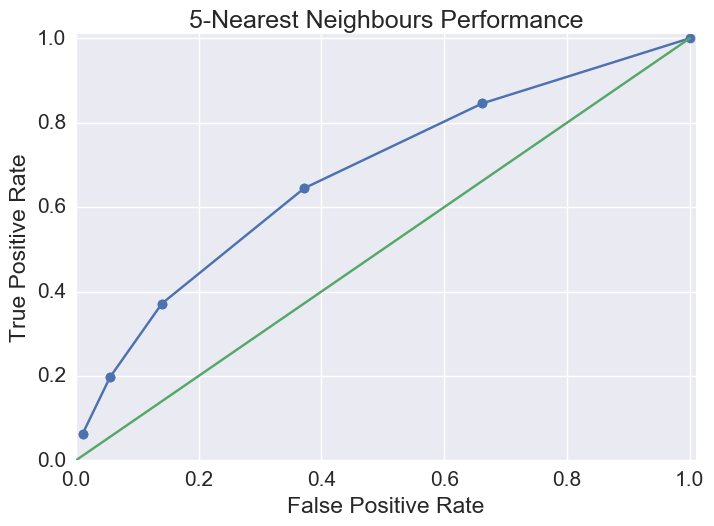

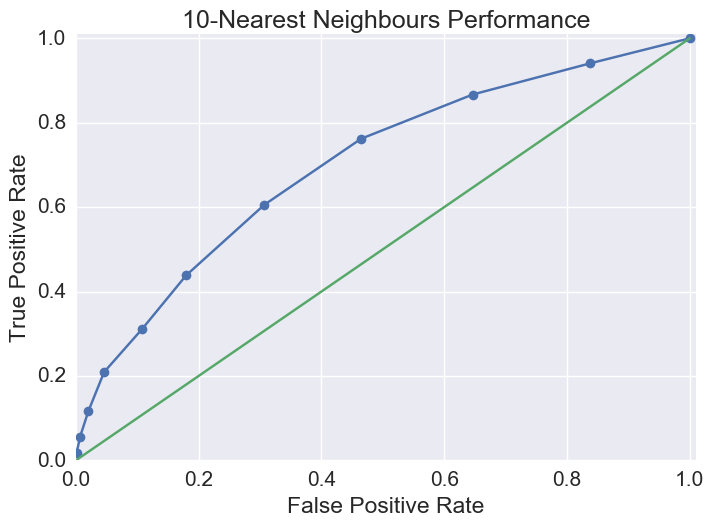

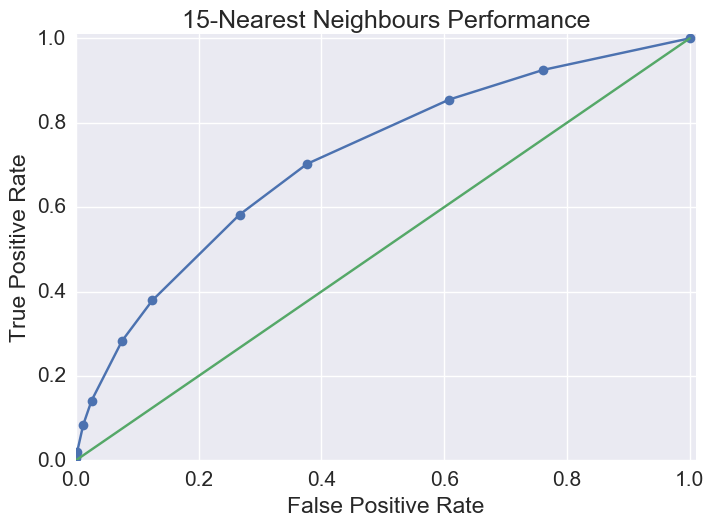

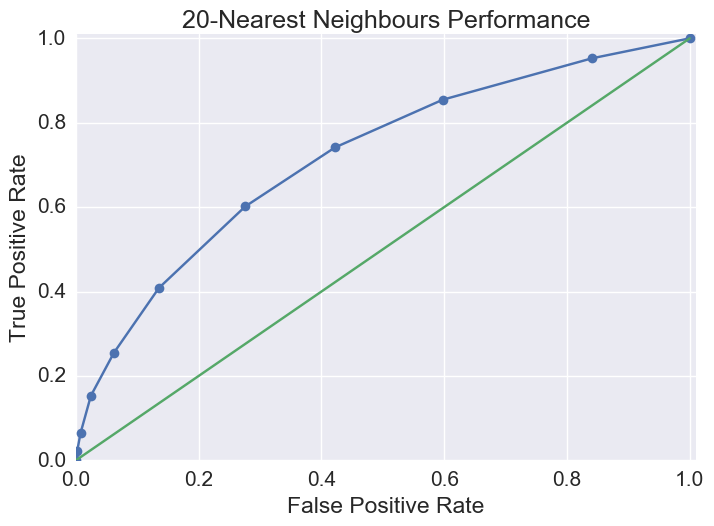

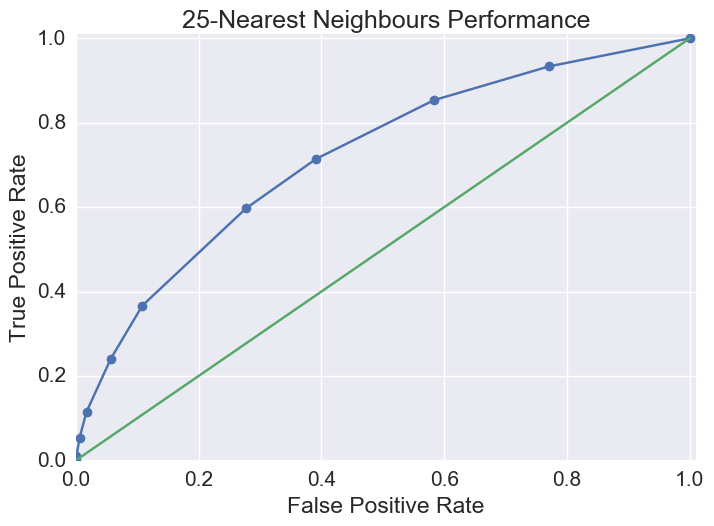

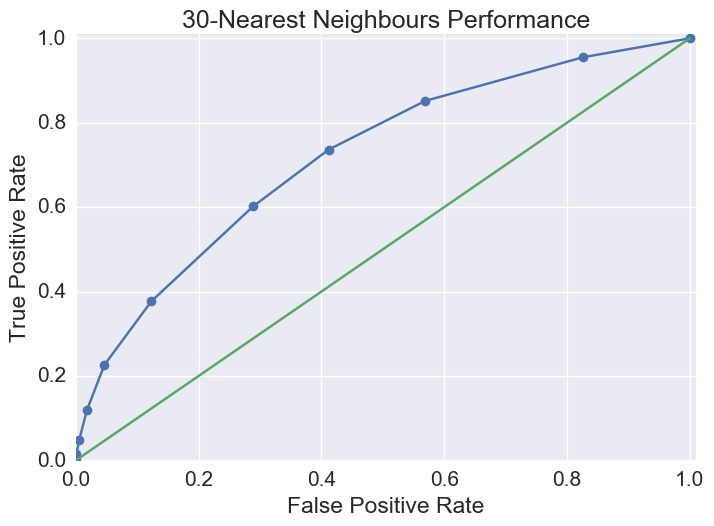

In [146]:
k_neigh = [2,3,4,5,10,15,20,25,30]

for k in k_neigh:
    knn_performance(active_df, k, 'no')

## K-Nearest Neighbours: New Donors

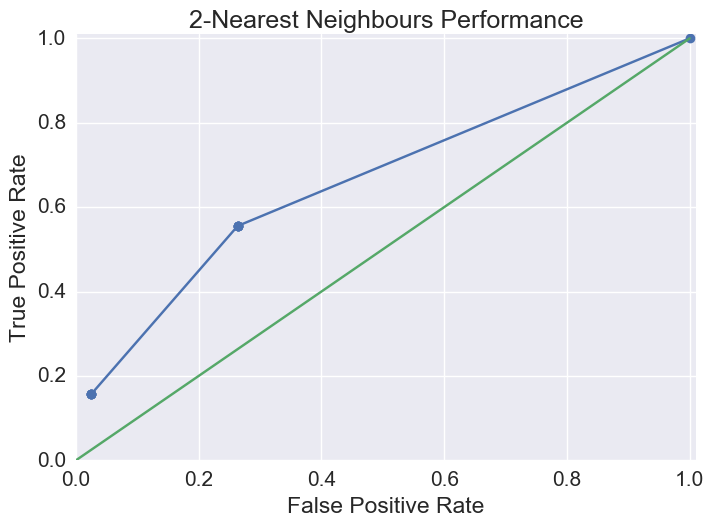

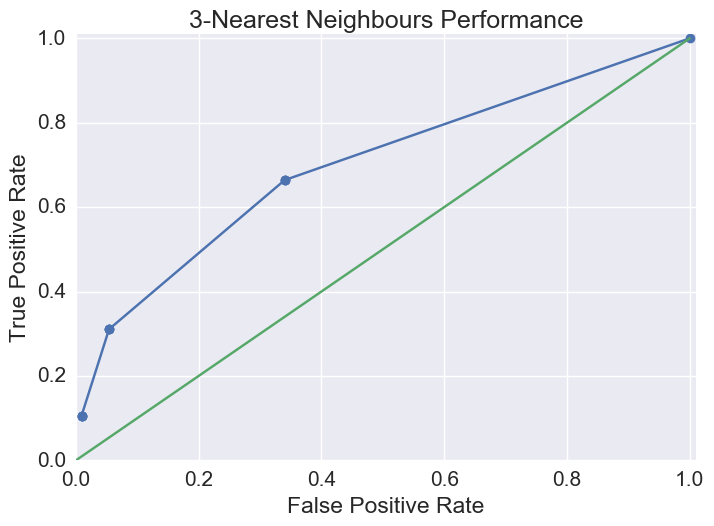

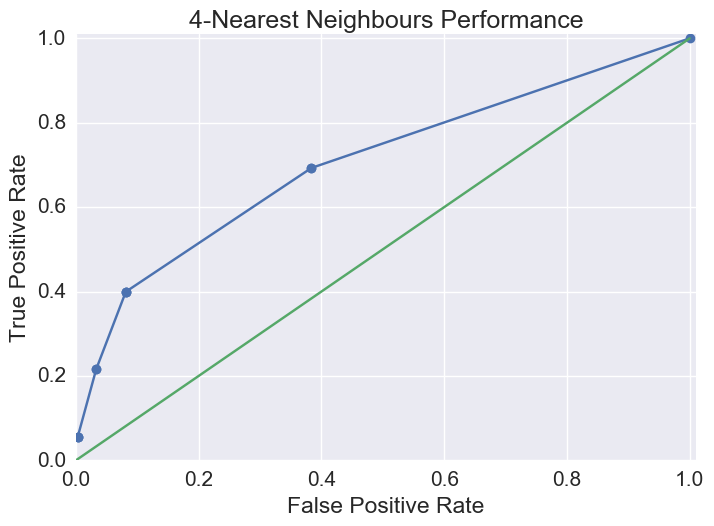

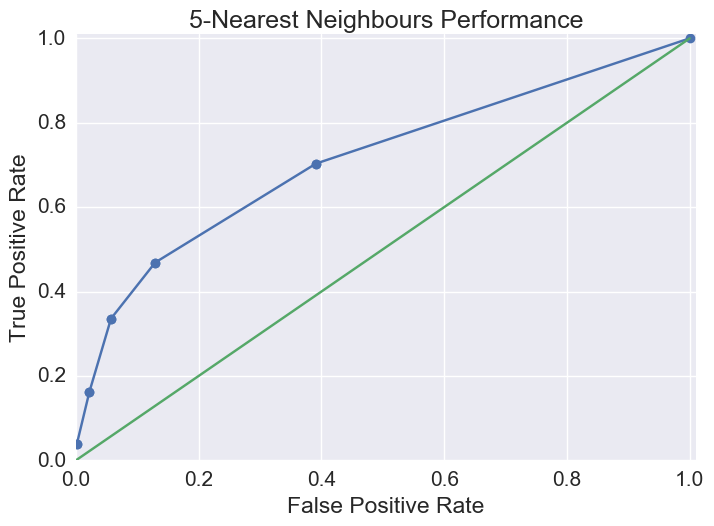

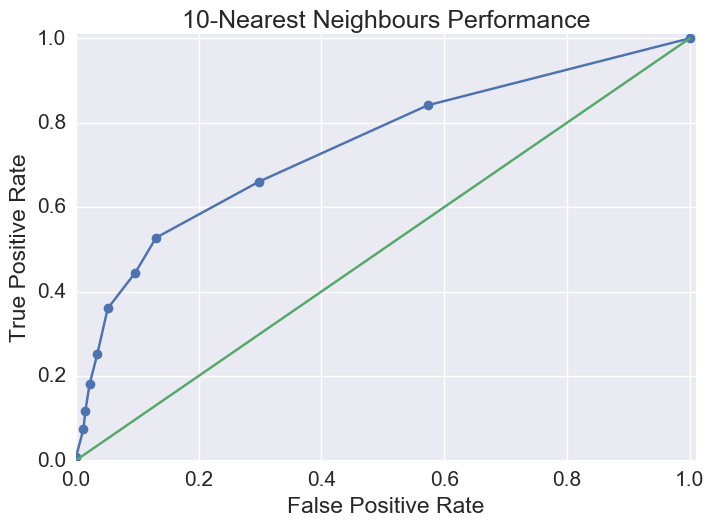

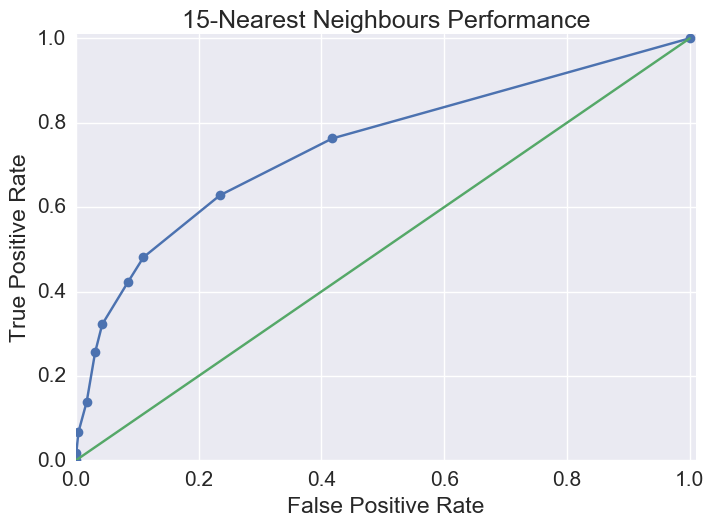

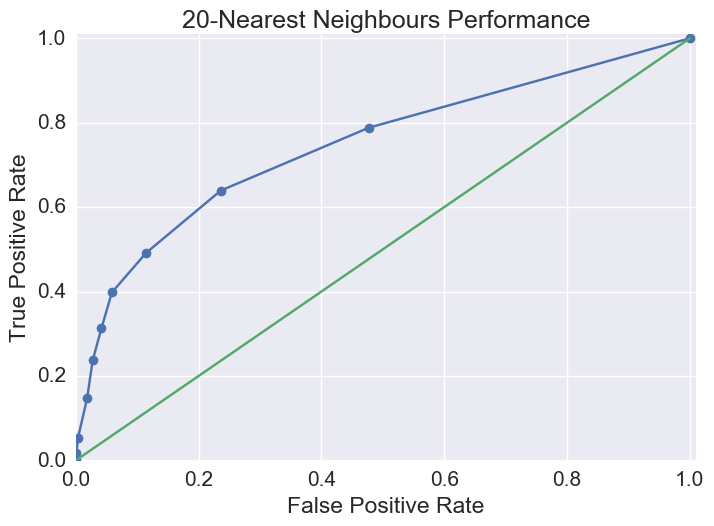

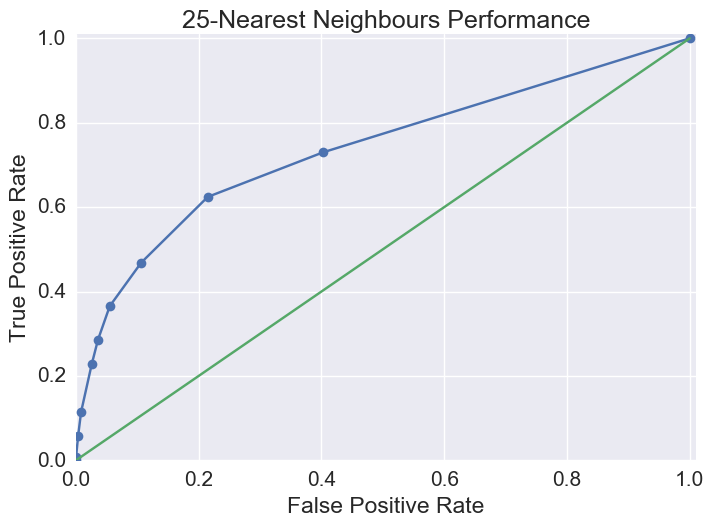

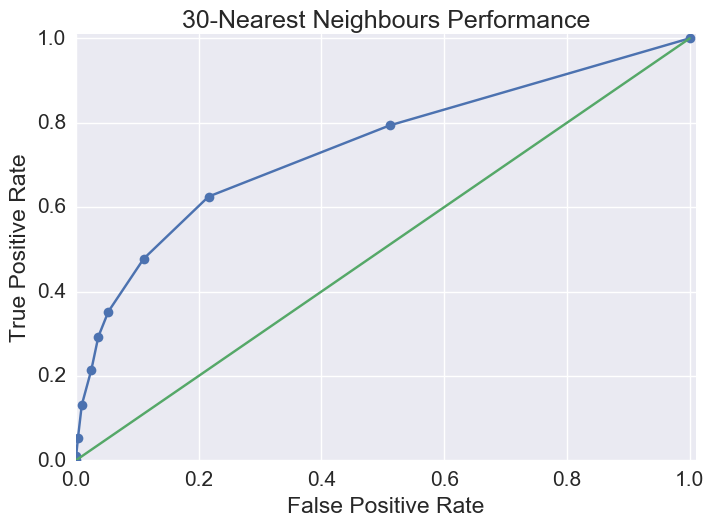

In [151]:
for k in k_neigh:
    knn_performance(new_df, k, 'no')

# Overall Summary

In this project we investigated and tested three common binary classification algorithms in an attempt to develop a tool that could assist in data selection for DM campaigns. We tried Logistic Regression, Random Forest and K-Nearest Neighbours on the same set of predictors. We began by performing an initial analysis to get a feeling of some of the variables and how they related to the 'donation' variable.

What we found is that **none of these classification algorithms performed very well on our dataset**. This is, in hindsight, not particularly surprising, since if a simple out-of-the-box algorithm could predict whether someone donates to a high degree, then probably a lot of people would be out of a job!

The nature of direct-marketing fundraising is simply not a problem that can easily be predicted. What we found is that **simple data analysis techniques go a long way in this arena**, and this was somewhat confirmed by the logistic regression model.

### Possible next steps

It's possible that the set of predictors we used is simply the wrong set and did not contain good variables to predict the outcome. We could try to re-think these predictors.

In this project, we also did not look at variable selection and optimising which variables to use. However, it's unlikely that any subset of variables of our predictors would drastically change the fit of these models.

We could potentially drill down our segments further to test classification models, i.e. build a model for Active donors in value bands 1 and 2 only. But by the time we drill down to this level, there's probably no need to build an accurate predictive model anyway, we should just mail all these donors. 